In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.stats import f_oneway
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from scipy.stats import kruskal
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [2]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [4]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [5]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

title_release_movies = df_movies.title + df_movies.release_date.astype(str)
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies

title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [6]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [7]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [8]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [9]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [10]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [11]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [13]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [14]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

In [16]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with more than one country
df_movies_ratings_imdb['country_count'] = df_movies_ratings_imdb['countries'].str.len()
movies_1_country = df_movies_ratings_imdb[df_movies_ratings_imdb['country_count'] == 1.0]
movies_1_or_2_country = df_movies_ratings_imdb[(df_movies_ratings_imdb['country_count'] == 1.0) | (df_movies_ratings_imdb['country_count'] == 2.0)]

movies_1_country_size = movies_1_country.size
movies_1_or_2_country_size = movies_1_or_2_country.size
all_movies = df_movies_ratings_imdb.size

percent_one_country = movies_1_country_size/all_movies
percent_one_or_two_country = movies_1_or_2_country_size/all_movies

print(f"{percent_one_country} of our ratings-populated movie metadataset have only one country listed.")
print(f"{percent_one_or_two_country} of our ratings-populated movie metadataset have one or two countries listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = movies_1_country
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['country_count'], axis = 1)

0.8652437957663759 of our ratings-populated movie metadataset have only one country listed.
0.9617624272111563 of our ratings-populated movie metadataset have one or two countries listed.


Given most movies have only one country listed, the other movies with more than one country are dropped to avoid redundancy of considering the same movie and thereby rating across regions.

In [17]:
# Evaluating movies with more than one genre
df_movies_ratings_imdb['genre_count'] = df_movies_ratings_imdb['genres'].str.len()
movies_1_genre = df_movies_ratings_imdb[df_movies_ratings_imdb['genre_count'] == 1.0]
movies_1_or_2_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0)]
movies_1_to_3_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0)]
movies_1_to_4_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0)]
movies_1_to_5_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0)]
movies_1_to_6_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0) | (df_movies_ratings_imdb['genre_count'] == 6.0)]

movies_1_genre_size = movies_1_genre.size
movies_1_or_2_genre_size = movies_1_or_2_genre.size
movies_1_to_3_genre_size = movies_1_to_3_genre.size
movies_1_to_4_genre_size = movies_1_to_4_genre.size
movies_1_to_5_genre_size = movies_1_to_5_genre.size
movies_1_to_6_genre_size = movies_1_to_6_genre.size
all_movies = df_movies_ratings_imdb.size

percent_one_genre = movies_1_genre_size/all_movies
percent_one_or_two_genre = movies_1_or_2_genre_size/all_movies
percent_one_to_three_genre = movies_1_to_3_genre_size/all_movies
percent_one_to_four_genre = movies_1_to_4_genre_size/all_movies
percent_one_to_five_genre = movies_1_to_5_genre_size/all_movies
percent_one_to_six_genre = movies_1_to_6_genre_size/all_movies

print(f"{percent_one_genre} of our ratings-populated movie metadataset have only one genre listed.")
print(f"{percent_one_or_two_genre} of our ratings-populated movie metadataset have one or two genres listed.")
print(f"{percent_one_to_three_genre} of our ratings-populated movie metadataset have one to three genres listed.")
print(f"{percent_one_to_four_genre} of our ratings-populated movie metadataset have one to four genres listed.")
print(f"{percent_one_to_five_genre} of our ratings-populated movie metadataset have one to five genres listed.")
print(f"{percent_one_to_six_genre} of our ratings-populated movie metadataset have one to six genres listed.")

0.19834782357528669 of our ratings-populated movie metadataset have only one genre listed.
0.3923919008694145 of our ratings-populated movie metadataset have one or two genres listed.
0.5690188036163022 of our ratings-populated movie metadataset have one to three genres listed.
0.720169839114988 of our ratings-populated movie metadataset have one to four genres listed.
0.8306808006701135 of our ratings-populated movie metadataset have one to five genres listed.
0.9043066347014818 of our ratings-populated movie metadataset have one to six genres listed.


The majority of movies do not have one genre listed, so some way of handling this must be considered. One technique could be to explode the genre lists for multigenre movies, select for the top 20 (or some other value) most occurring genre, and then recombine the multigenre movies with only these relevant genres. However, considering we'd want to keep at least 90% of the movies which corresponds to movies having up to six genres, then in the 'worst-case' scenario there could be 6^20 possible recombinations of the top 20 genres. Our data would obviously not explore this entire combinatorial space, however, we would be analying hundreds of genres. Alternatively, the first genre listed in a movie's entry could be considered as the most relevant one and kept as the sole genre for multigenre movies. The issue here is we fear we are missing information about movies if we discard their other pertinent genres. Instead, we opt to explode all movies genres, then select for the top 20 most occurring genres, then preserve only movie entries with one of those top 20 genres listed.

In [18]:
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

In [19]:
df_movies_tmdb_ratings = df_movies_ratings_imdb.copy()

# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [20]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [21]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 32977 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [22]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

# Ratings Analysis

The analysis is heavily based on the `averageRating` feature. To better understand its statistics, its description is displayed.

In [23]:
df_movies_tmdb_ratings["averageRating"].describe()

count    77954.000000
mean         6.162507
std          1.081180
min          1.100000
25%          5.600000
50%          6.300000
75%          6.900000
max          9.500000
Name: averageRating, dtype: float64

The movie ratings found for part of the CMU dataset have a mean -- which it is reported owing to the above conclusion of the mean ratings being approximately normal -- of 3.15. The standard deviation is 0.6 and no ratings under 0.5 are observed, whereas perfect ratings are observed.

In [24]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_tmdb_ratings['averageRating'], color='white', linecolor='black', width=0.3)

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,10.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

plt.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a five point scale and no extreme values greatly drive skew in the movies ratings. The plot below provides further information on the mean movie ratings distribution. Ratings are again given in a range from 0 to 5.

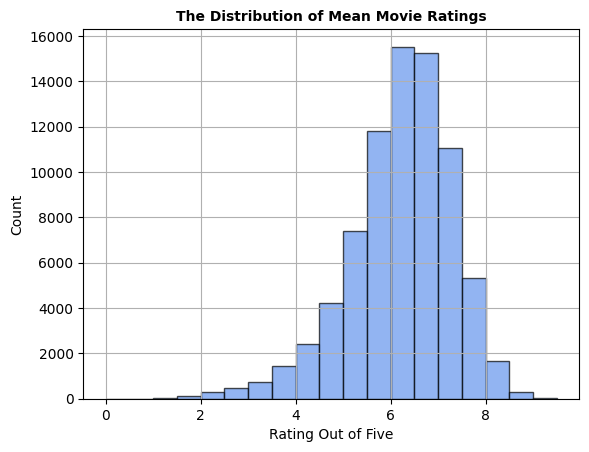

In [25]:
bin_edges = np.arange(0, df_movies_tmdb_ratings['averageRating'].max() + 0.5, 0.5)
plt.hist(df_movies_tmdb_ratings['averageRating'].values, edgecolor='black', alpha=0.7, bins = bin_edges, color='cornflowerblue')
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Five', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)

Since even through this visualization the distribution resembles a normal one, some test to verify this hypothesis are run below.

In [26]:
diagnostic.kstest_normal(df_movies_tmdb_ratings['averageRating'].values, dist = 'norm') 

(0.072055750602532, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, visual inspections of the ratings distribution lead to a different conclusion. Therefore, a Q-Q plot is again employed to further assess normality.

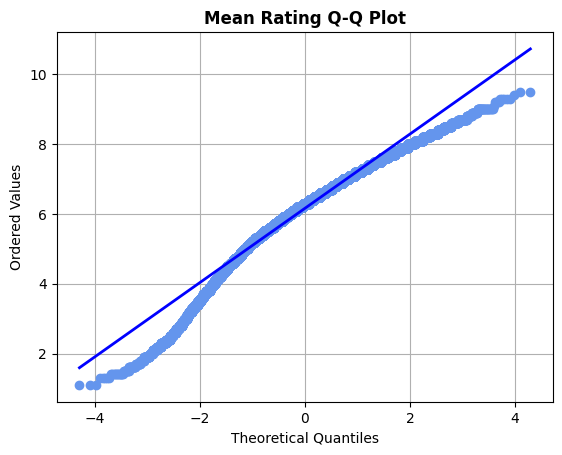

In [27]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings['averageRating'].values, dist="norm", plot=ax)

# line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

In [28]:
genres_total = df_movies_tmdb_ratings.groupby("genres").count().sort_values("wikipedia_id", ascending=False).reset_index()
top_20_genres = genres_total.loc[:19, "genres"]
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_20_genres)]

top_20_genres_list = top_20_genres.to_list()

Text(50.72222222222221, 0.5, 'Genres')

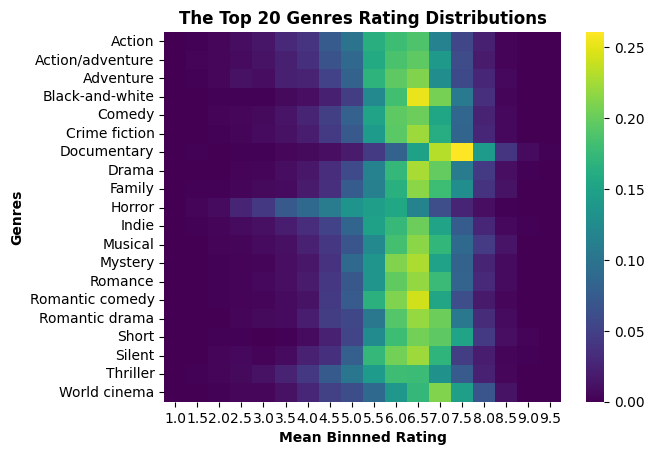

In [29]:
# making the mean of each movie's rating an increment of 0.5
df_movies_tmdb_ratings_top20genres_binnedratings = df_movies_tmdb_ratings_top20genres.copy()
df_movies_tmdb_ratings_top20genres_binnedratings["averageRating"] = df_movies_tmdb_ratings_top20genres_binnedratings["averageRating"].apply(lambda x: round(x*2)/2)

df_genres_meanratings = pd.crosstab(df_movies_tmdb_ratings_top20genres_binnedratings['genres'],df_movies_tmdb_ratings_top20genres_binnedratings['averageRating'], normalize='index')

# creating an heatmap among the top 20 genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis', ax = ax)

ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 3.0 and 3.5 rating bins, as expected given the population's mean rating of 3.15. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

In [30]:
# starting by plotting the relationship between movies with reasonable runtimes (over 20 minutes, despite short films
# having lesser time than this as there are many incorrect runtimes observed under 20 minutes) and mean rating
nonzero_runtimes = df_movies_tmdb_ratings[df_movies_tmdb_ratings['runtime'] > 20.0]["runtime"]
nonzero_runtimes_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['runtime'] > 20.0]["averageRating"]
nonzero_runtimes_genres = df_movies_tmdb_ratings[df_movies_tmdb_ratings['runtime'] > 20.0]["genres"]
runtime_ratings = pd.concat([nonzero_runtimes, nonzero_runtimes_ratings, nonzero_runtimes_genres], axis=1)

sns.lmplot(x='runtime',y='averageRating', data=runtime_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime")
plt.ylabel("IMDB Rating")
plt.title("The Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

This is obviously difficult to visualize, so a density plot is used instead.

In [31]:
plt.hexbin(runtime_ratings["runtime"], runtime_ratings["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Frequency")
plt.xlabel("Film Runtime")
plt.ylabel("IMDB Rating")
plt.title("Density of Runtime vs IMDB Rating", weight='bold')
plt.show()

This relationship per genre would also be interesting.

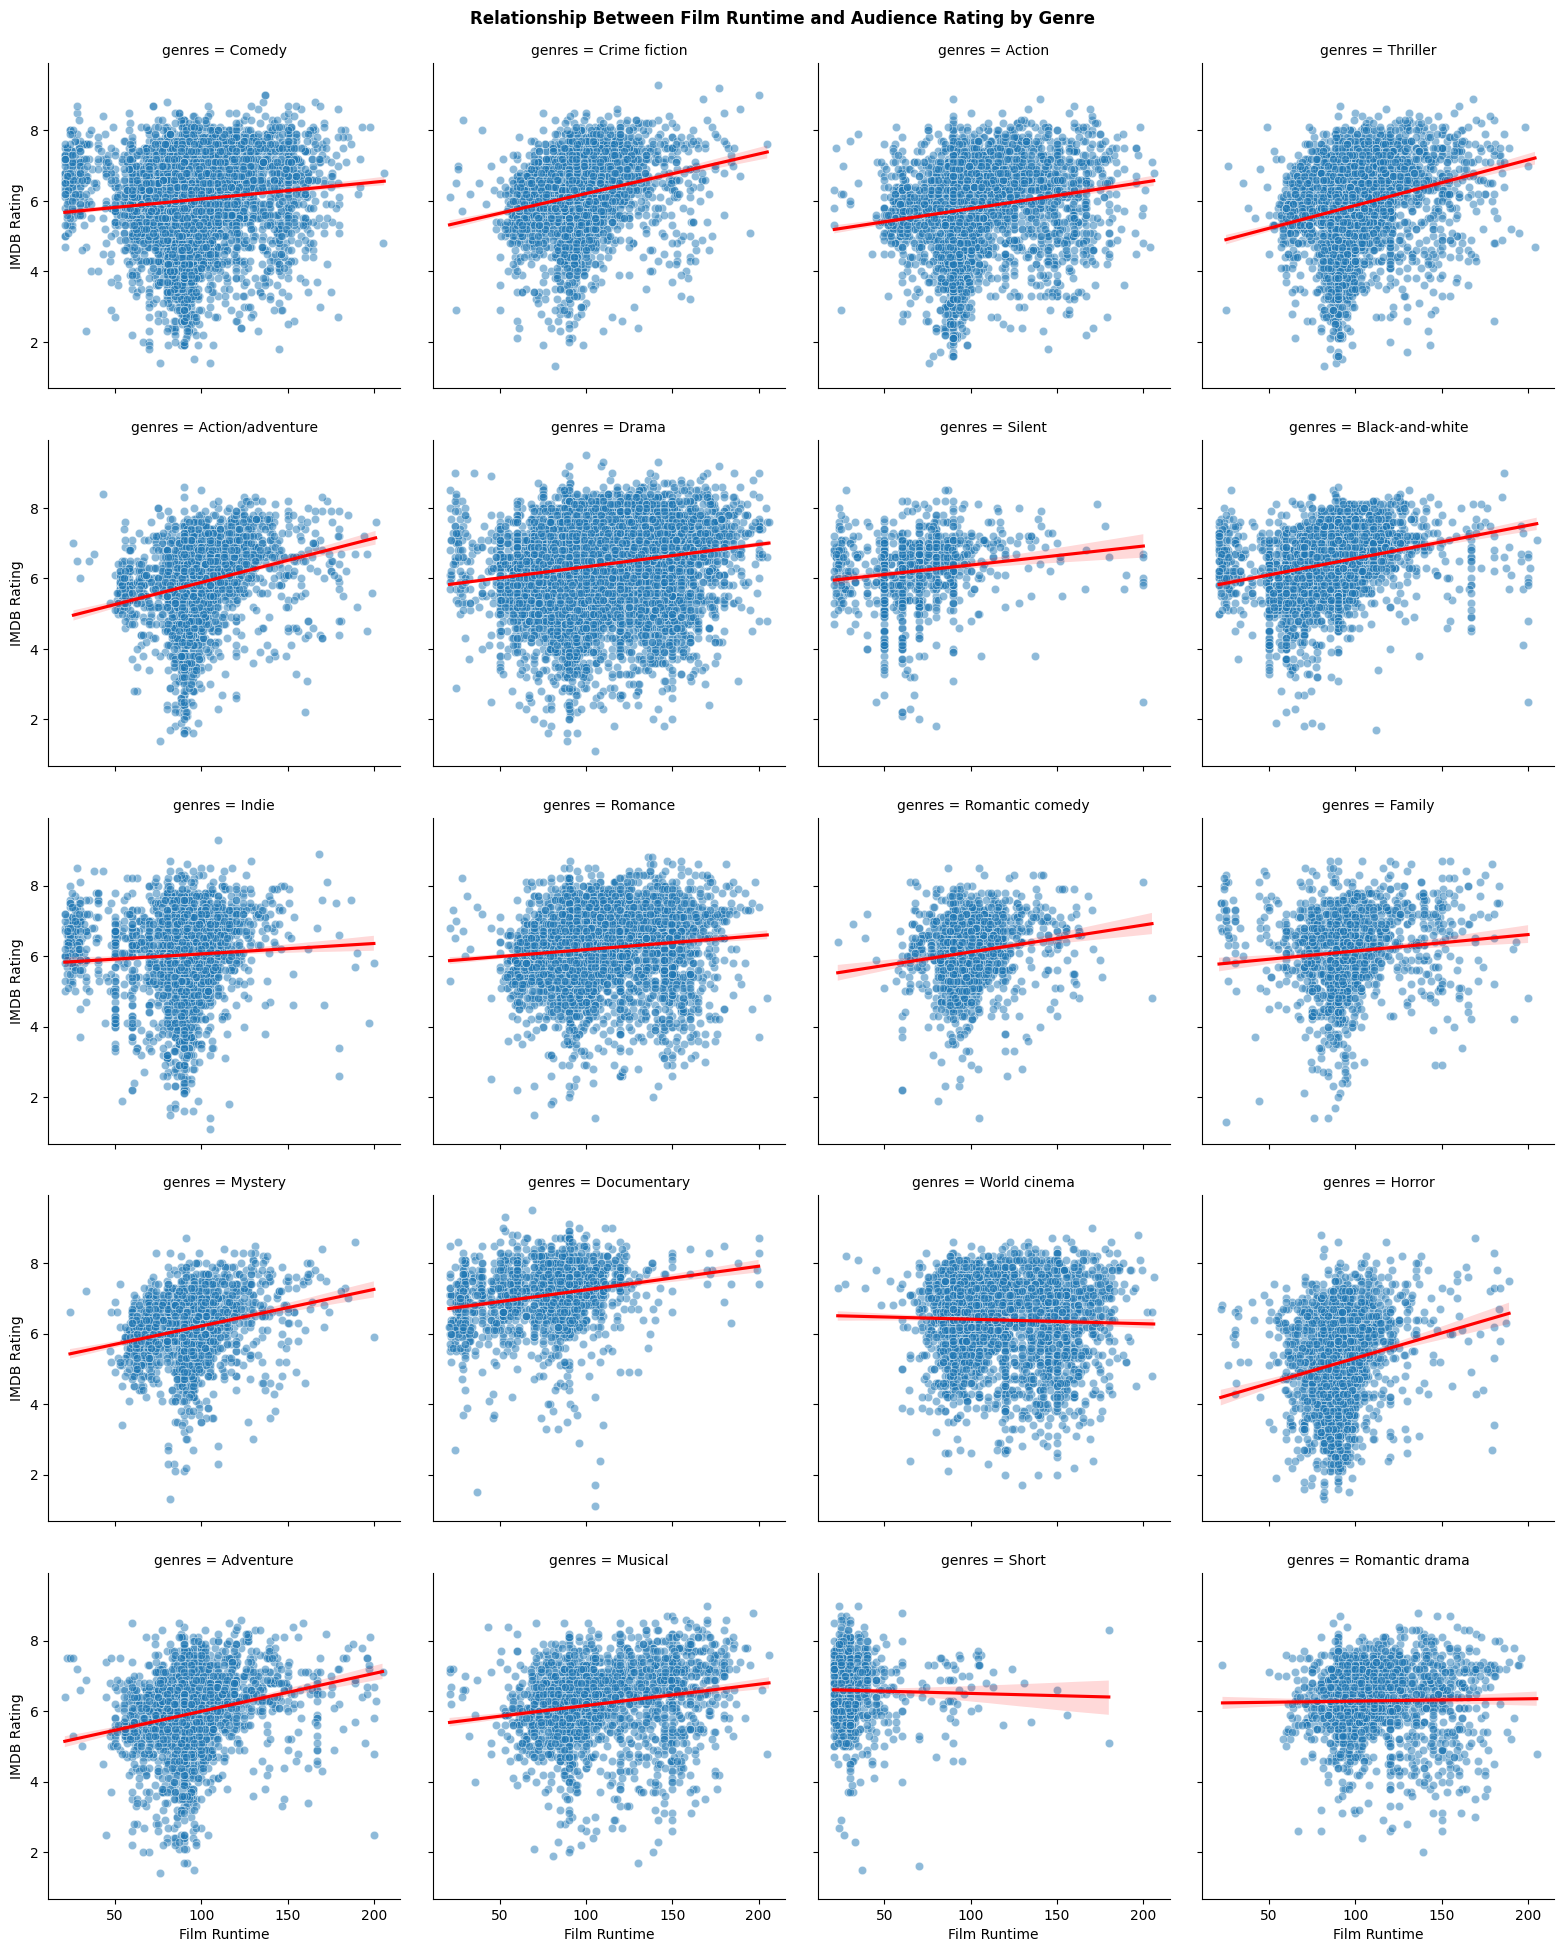

In [32]:
seperated_genres = sns.FacetGrid(runtime_ratings, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)
seperated_genres.map(sns.scatterplot, "runtime", "averageRating", alpha=0.5)
seperated_genres.map(sns.regplot, "runtime", "averageRating", scatter=False, color='red')
seperated_genres.set_axis_labels("Film Runtime", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Runtime and Audience Rating by Genre", weight='bold')
seperated_genres.tight_layout(pad=2)
plt.show()

In [33]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(runtime_ratings['runtime'], runtime_ratings['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(runtime_ratings['runtime'], runtime_ratings['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.1222, p-value: 0.0000
Spearman correlation: 0.1767, p-value: 0.0000


The same plots can been computed to compare the rating and the release date.

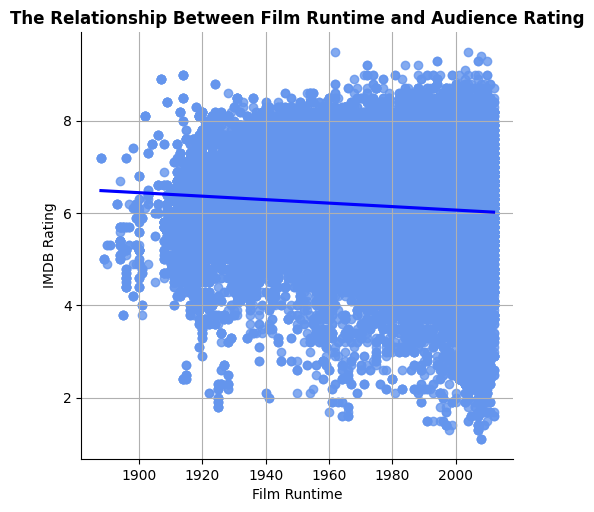

In [34]:
sns.lmplot(x='release_date',y='averageRating', data=df_movies_tmdb_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime")
plt.ylabel("IMDB Rating")
plt.title("The Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

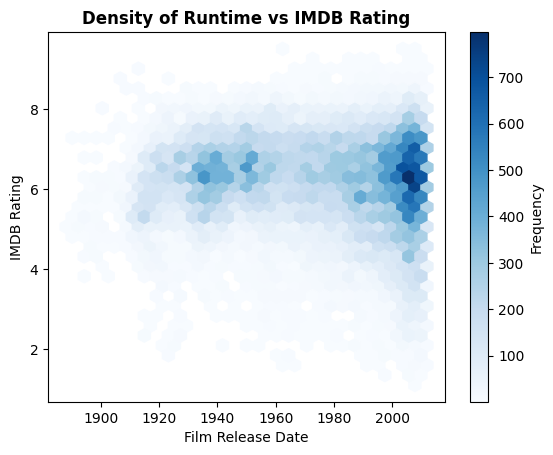

In [35]:
plt.hexbin(df_movies_tmdb_ratings["release_date"], df_movies_tmdb_ratings["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Frequency")
plt.xlabel("Film Release Date")
plt.ylabel("IMDB Rating")
plt.title("Density of Runtime vs IMDB Rating", weight='bold')
plt.show()

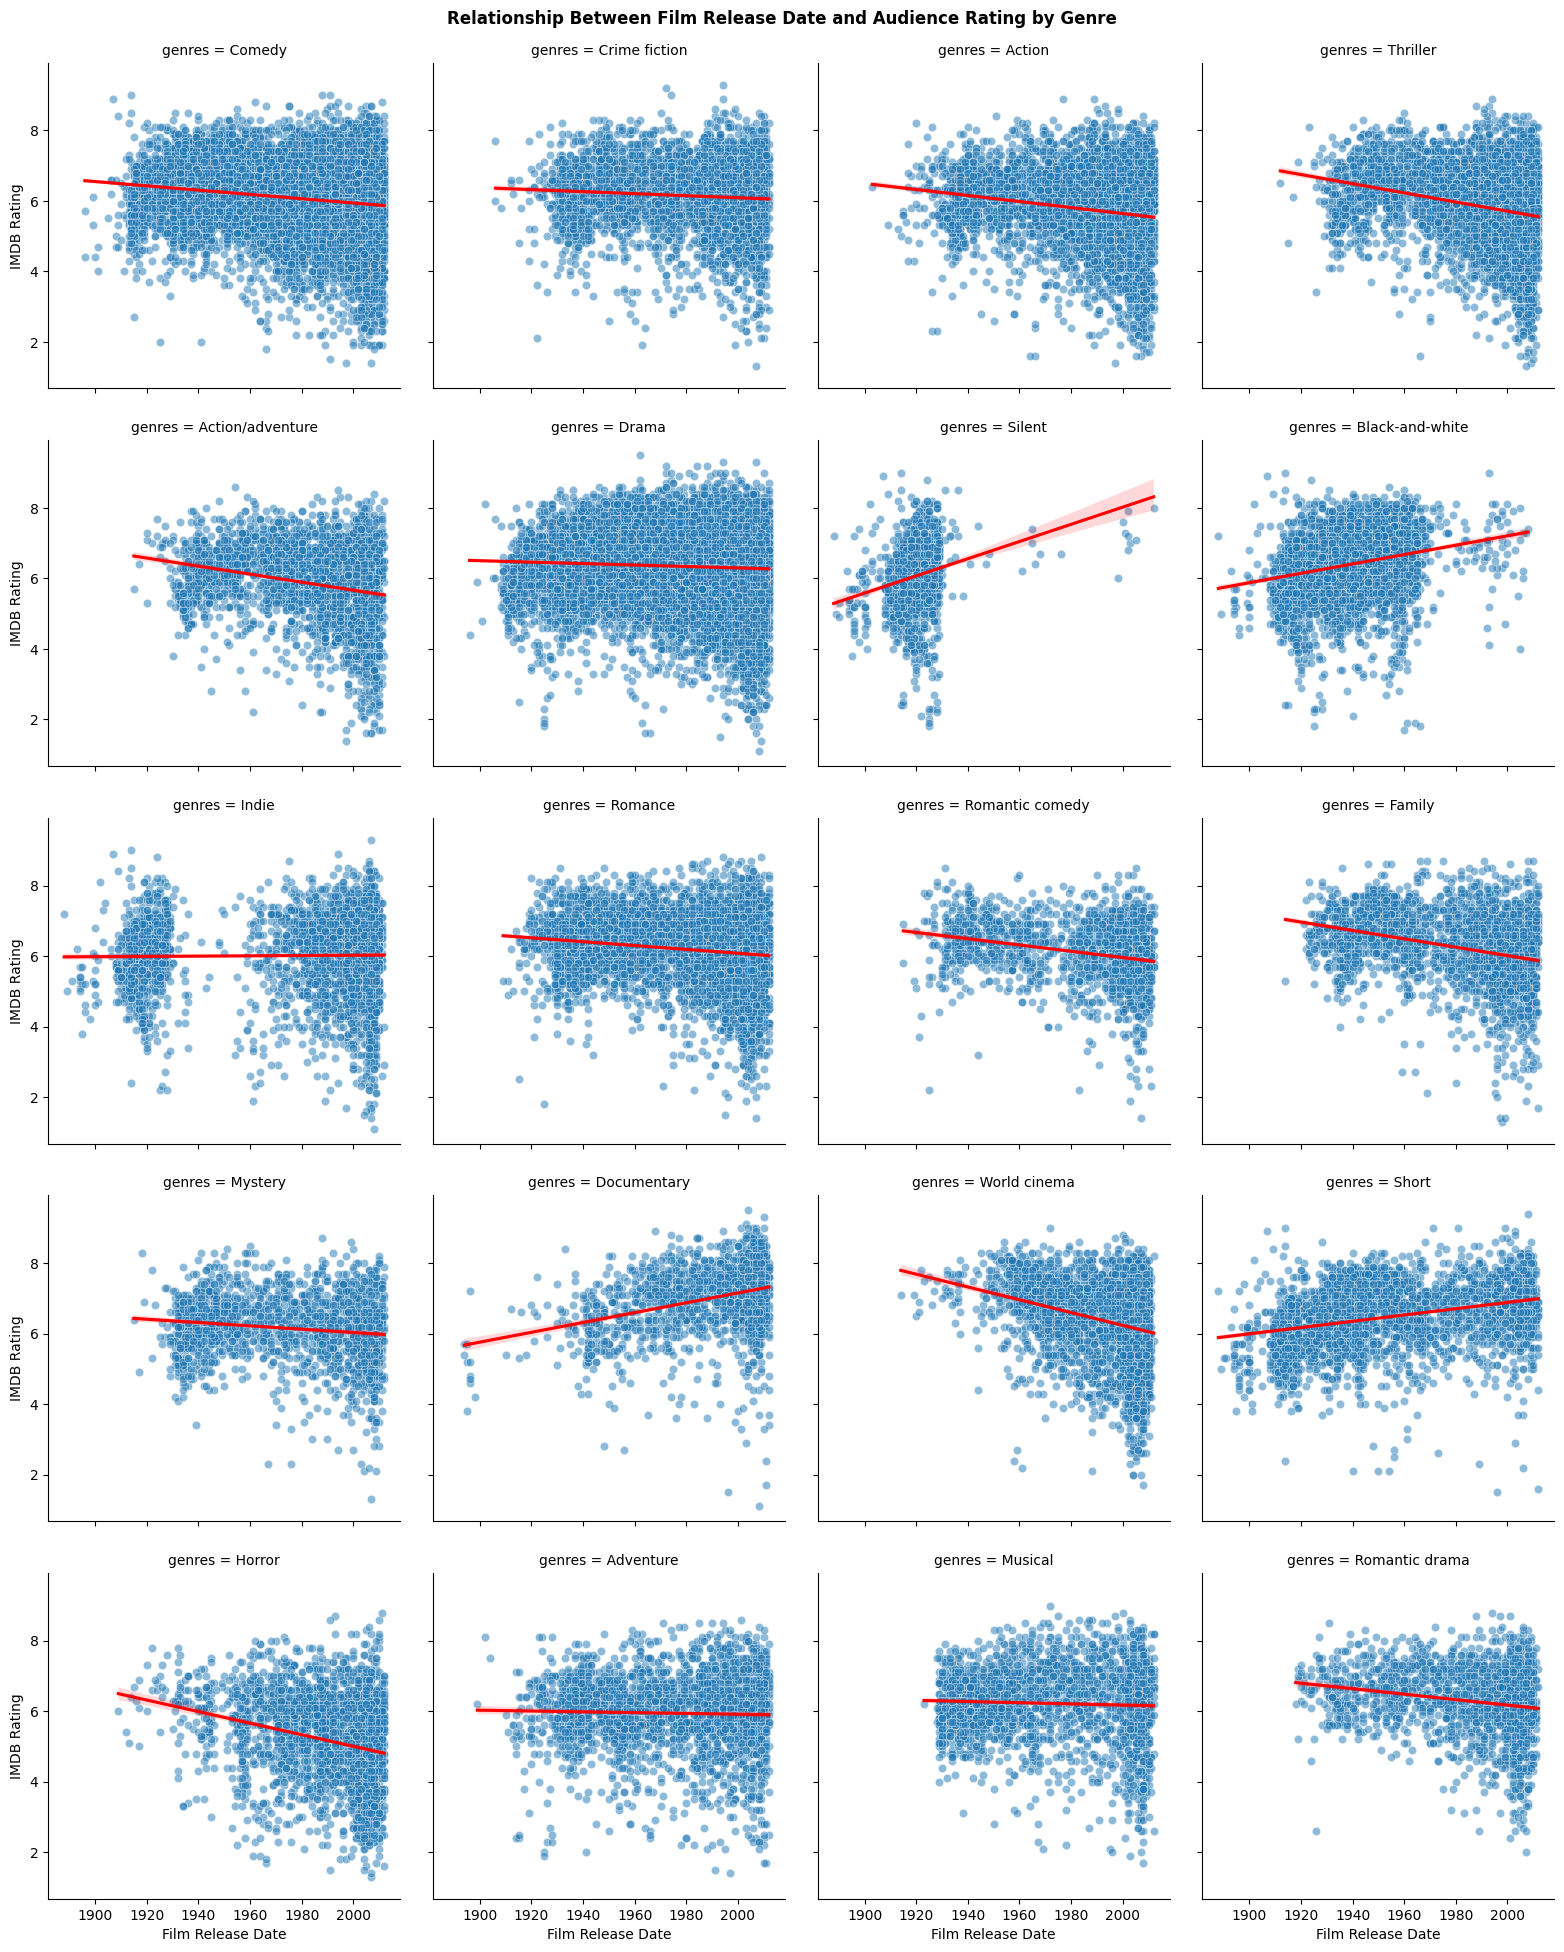

In [36]:
seperated_genres = sns.FacetGrid(df_movies_tmdb_ratings, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)
seperated_genres.map(sns.scatterplot, "release_date", "averageRating", alpha=0.5)
seperated_genres.map(sns.regplot, "release_date", "averageRating", scatter=False, color='red')
seperated_genres.set_axis_labels("Film Release Date", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Release Date and Audience Rating by Genre", weight='bold')
seperated_genres.tight_layout(pad=2)
plt.show()

In [37]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_tmdb_ratings['release_date'], df_movies_tmdb_ratings['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_tmdb_ratings['release_date'], df_movies_tmdb_ratings['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.1028, p-value: 0.0000
Spearman correlation: -0.0857, p-value: 0.0000


# Film ratings across regions and genres, over time

To simplify this analysis, the top twenty genres of movies are analyzed for their ratings across geographical regions and time of production.

In [38]:
# Identifying the continents and genres of interest
model_groupings = ['Central and South America', 'Eastern Europe', 'India',  
                   'North Africa and Middle East', "North America", "Oceania", 'Remaining Asia', 'South Africa and Central Africa', 'Western Europe']

In [39]:
# Storing colors for plotting later on (extending the colors list to 20 genres)
colors = plt.colormaps['tab20'].colors

In [40]:
# Identifying if any country does not have a particular genre
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                print(f"The geographical region {i} does not have a movie for the genre {genre}.")

The geographical region South Africa and Central Africa does not have a movie for the genre Black-and-white.


The geographical region North Africa and Middle East does not have a movie for the genre Indie.
The geographical region South Africa and Central Africa does not have a movie for the genre Musical.
The geographical region North Africa and Middle East does not have a movie for the genre Silent.
The geographical region South Africa and Central Africa does not have a movie for the genre Silent.


In [41]:
# Filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_tmdb_ratings_regionfilled = df_movies_tmdb_ratings.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                    new_row = {"region": i, "genres": genre, "averageRating": 0.0}
                    df_movies_tmdb_ratings_regionfilled = pd.concat([df_movies_tmdb_ratings_regionfilled, pd.DataFrame([new_row])], ignore_index=True)
# Identifying if any country does not have a particular genre again, which shouldn't be the case
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                print(f"The geographical region {i} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one Drama movie.
Every region has at least one Comedy movie.
Every region has at least one Romance movie.
Every region has at least one Black-and-white movie.
Every region has at least one Action movie.
Every region has at least one Thriller movie.
Every region has at least one Crime fiction movie.
Every region has at least one Indie movie.
Every region has at least one Short movie.
Every region has at least one World cinema movie.
Every region has at least one Action/adventure movie.
Every region has at least one Horror movie.
Every region has at least one Adventure movie.
Every region has at least one Family movie.
Every region has at least one Musical movie.
Every region has at least one Documentary movie.
Every region has at least one Romantic drama movie.
Every region has at least one Mystery movie.
Every region has at least one Romantic comedy movie.
Every region has at least one Silent movie.


In [42]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region
mean_ratings = {}
confidence_intervals = {}

# Loop through each genre and calculate the necessary values
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]

    # Group by region and calculate mean ratings and stderr
    genre_mean_ratings = genre_df.groupby("region")

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").apply(lambda x: round(x*2)/2).sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Store the mean ratings and confidence intervals for the genre
    genre_means = []
    genre_CI = []
    for region in model_groupings:
        # To ensure validity of results, must ensure a given region grouping for a given genre has at least 10 movies for their associated statistics to be reported
        if genre_mean_ratings_size.loc[region]<10:
            mean_rating = 0.0
            genre_means.append(mean_rating)
        else:
            mean_rating = genre_mean_ratings_regions_average.loc[region]["averageRating"]
            genre_means.append(mean_rating)

        # Calculate the 95% confidence interval (mean +/- 1.96 * stderr)
        if genre_mean_ratings_size.loc[region]<10:
            CI = 0.0
            genre_CI.append(CI)
        else:
            CI = genre_mean_ratings_regions_stderr.loc[region] * 1.96
            genre_CI.append(CI)

    # Append the results to the dictionaries
    mean_ratings[genre] = genre_means
    confidence_intervals[genre] = genre_CI

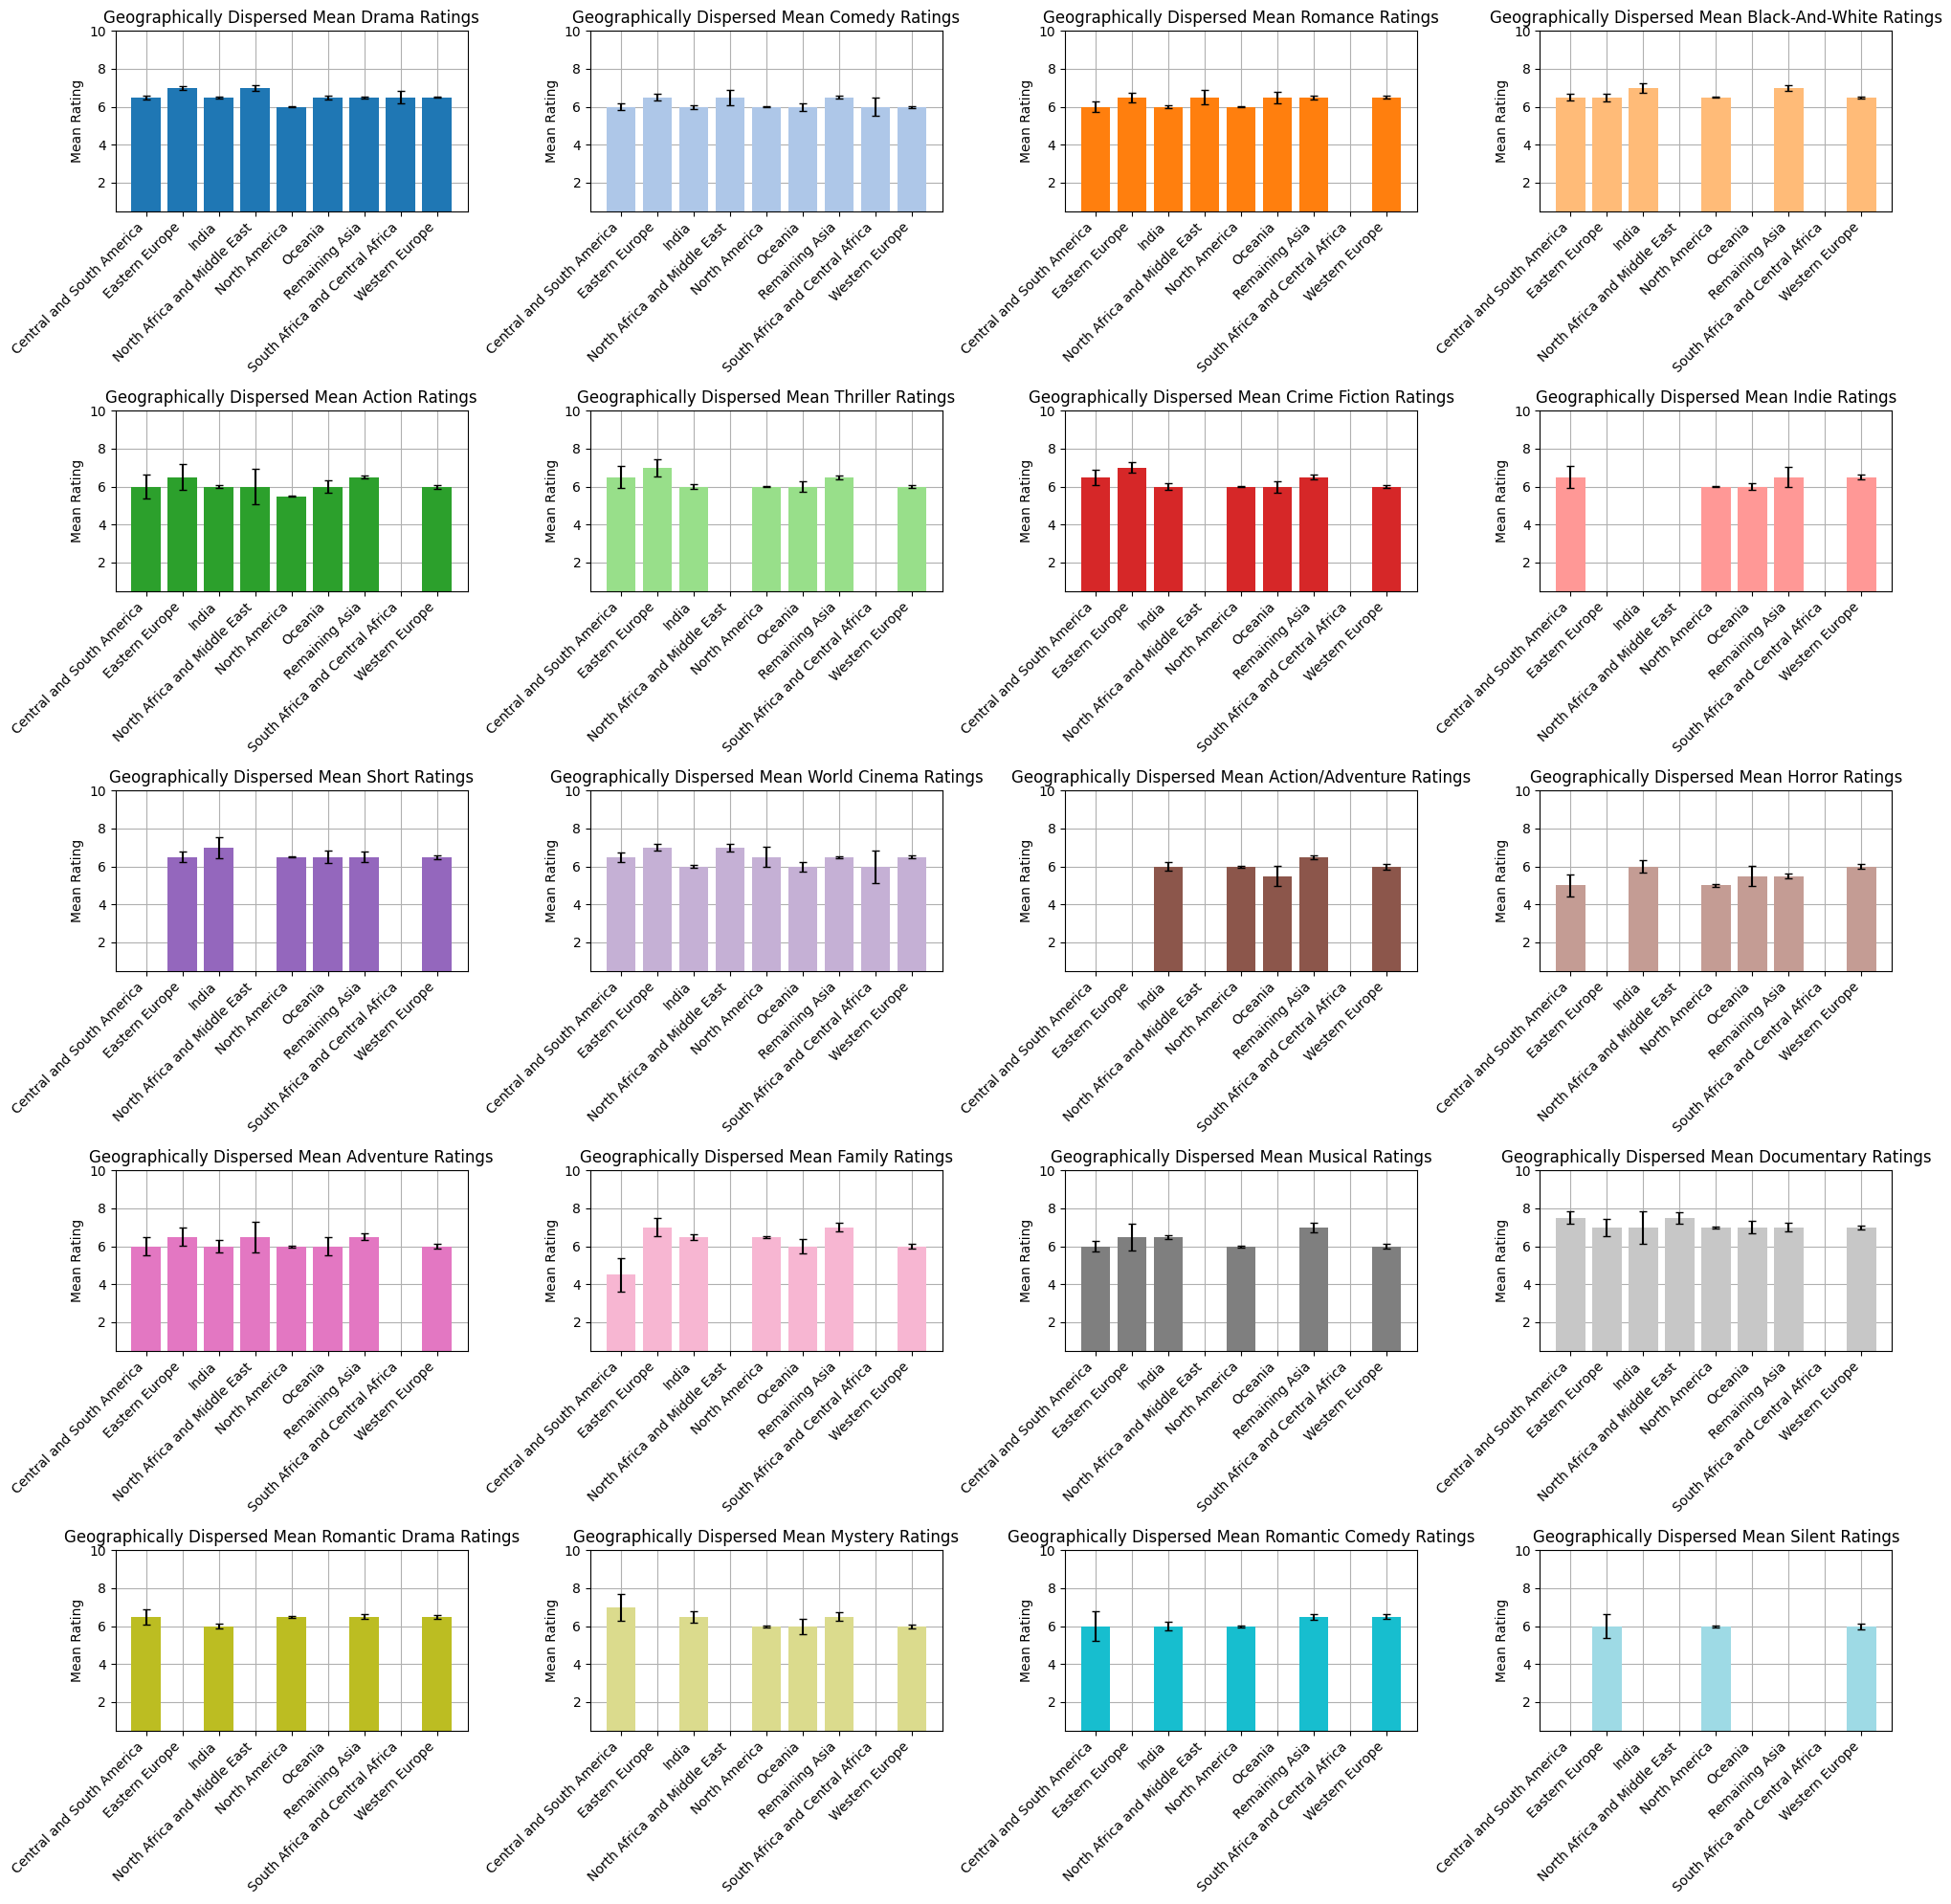

In [43]:
# Create a 5x4 grid for the subplots to fit 20 genres
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()

# Plot each genre in the corresponding subplot
for i, genre in enumerate(top_20_genres_list):
    axs[i].bar(range(len(model_groupings)), mean_ratings[genre], yerr=confidence_intervals[genre], capsize=3, color=colors[i], zorder=2)

    axs[i].grid(True, zorder=0)
    axs[i].set_xticks(range(len(model_groupings)))
    axs[i].set_xticklabels(model_groupings, rotation=45, ha='right')
    axs[i].set_title(f"Geographically Dispersed Mean {genre.title()} Ratings")
    axs[i].set_ylabel("Mean Rating")
    axs[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now I want to explore how within each geographical region the mean ratings of movies by genre differ.

In [44]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region
mean_ratings = {}
confidence_intervals = {}

# Loop through each genre and calculate the necessary values
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["region"] == region]

    # Group by region and calculate mean ratings and stderr
    genre_mean_ratings = region_df.groupby("genres")

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").apply(lambda x: round(x*2)/2).sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Store the mean ratings and confidence intervals for the genre
    region_means = []
    region_CI = []
    for genre in top_20_genres_list:
        mean_rating = genre_mean_ratings_regions_average.loc[genre]["averageRating"]
        region_means.append(mean_rating)

        # Calculate the 95% confidence interval (mean +/- 1.96 * stderr)
        CI = genre_mean_ratings_regions_stderr.loc[genre] * 1.96
        region_CI.append(CI)

    # Append the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

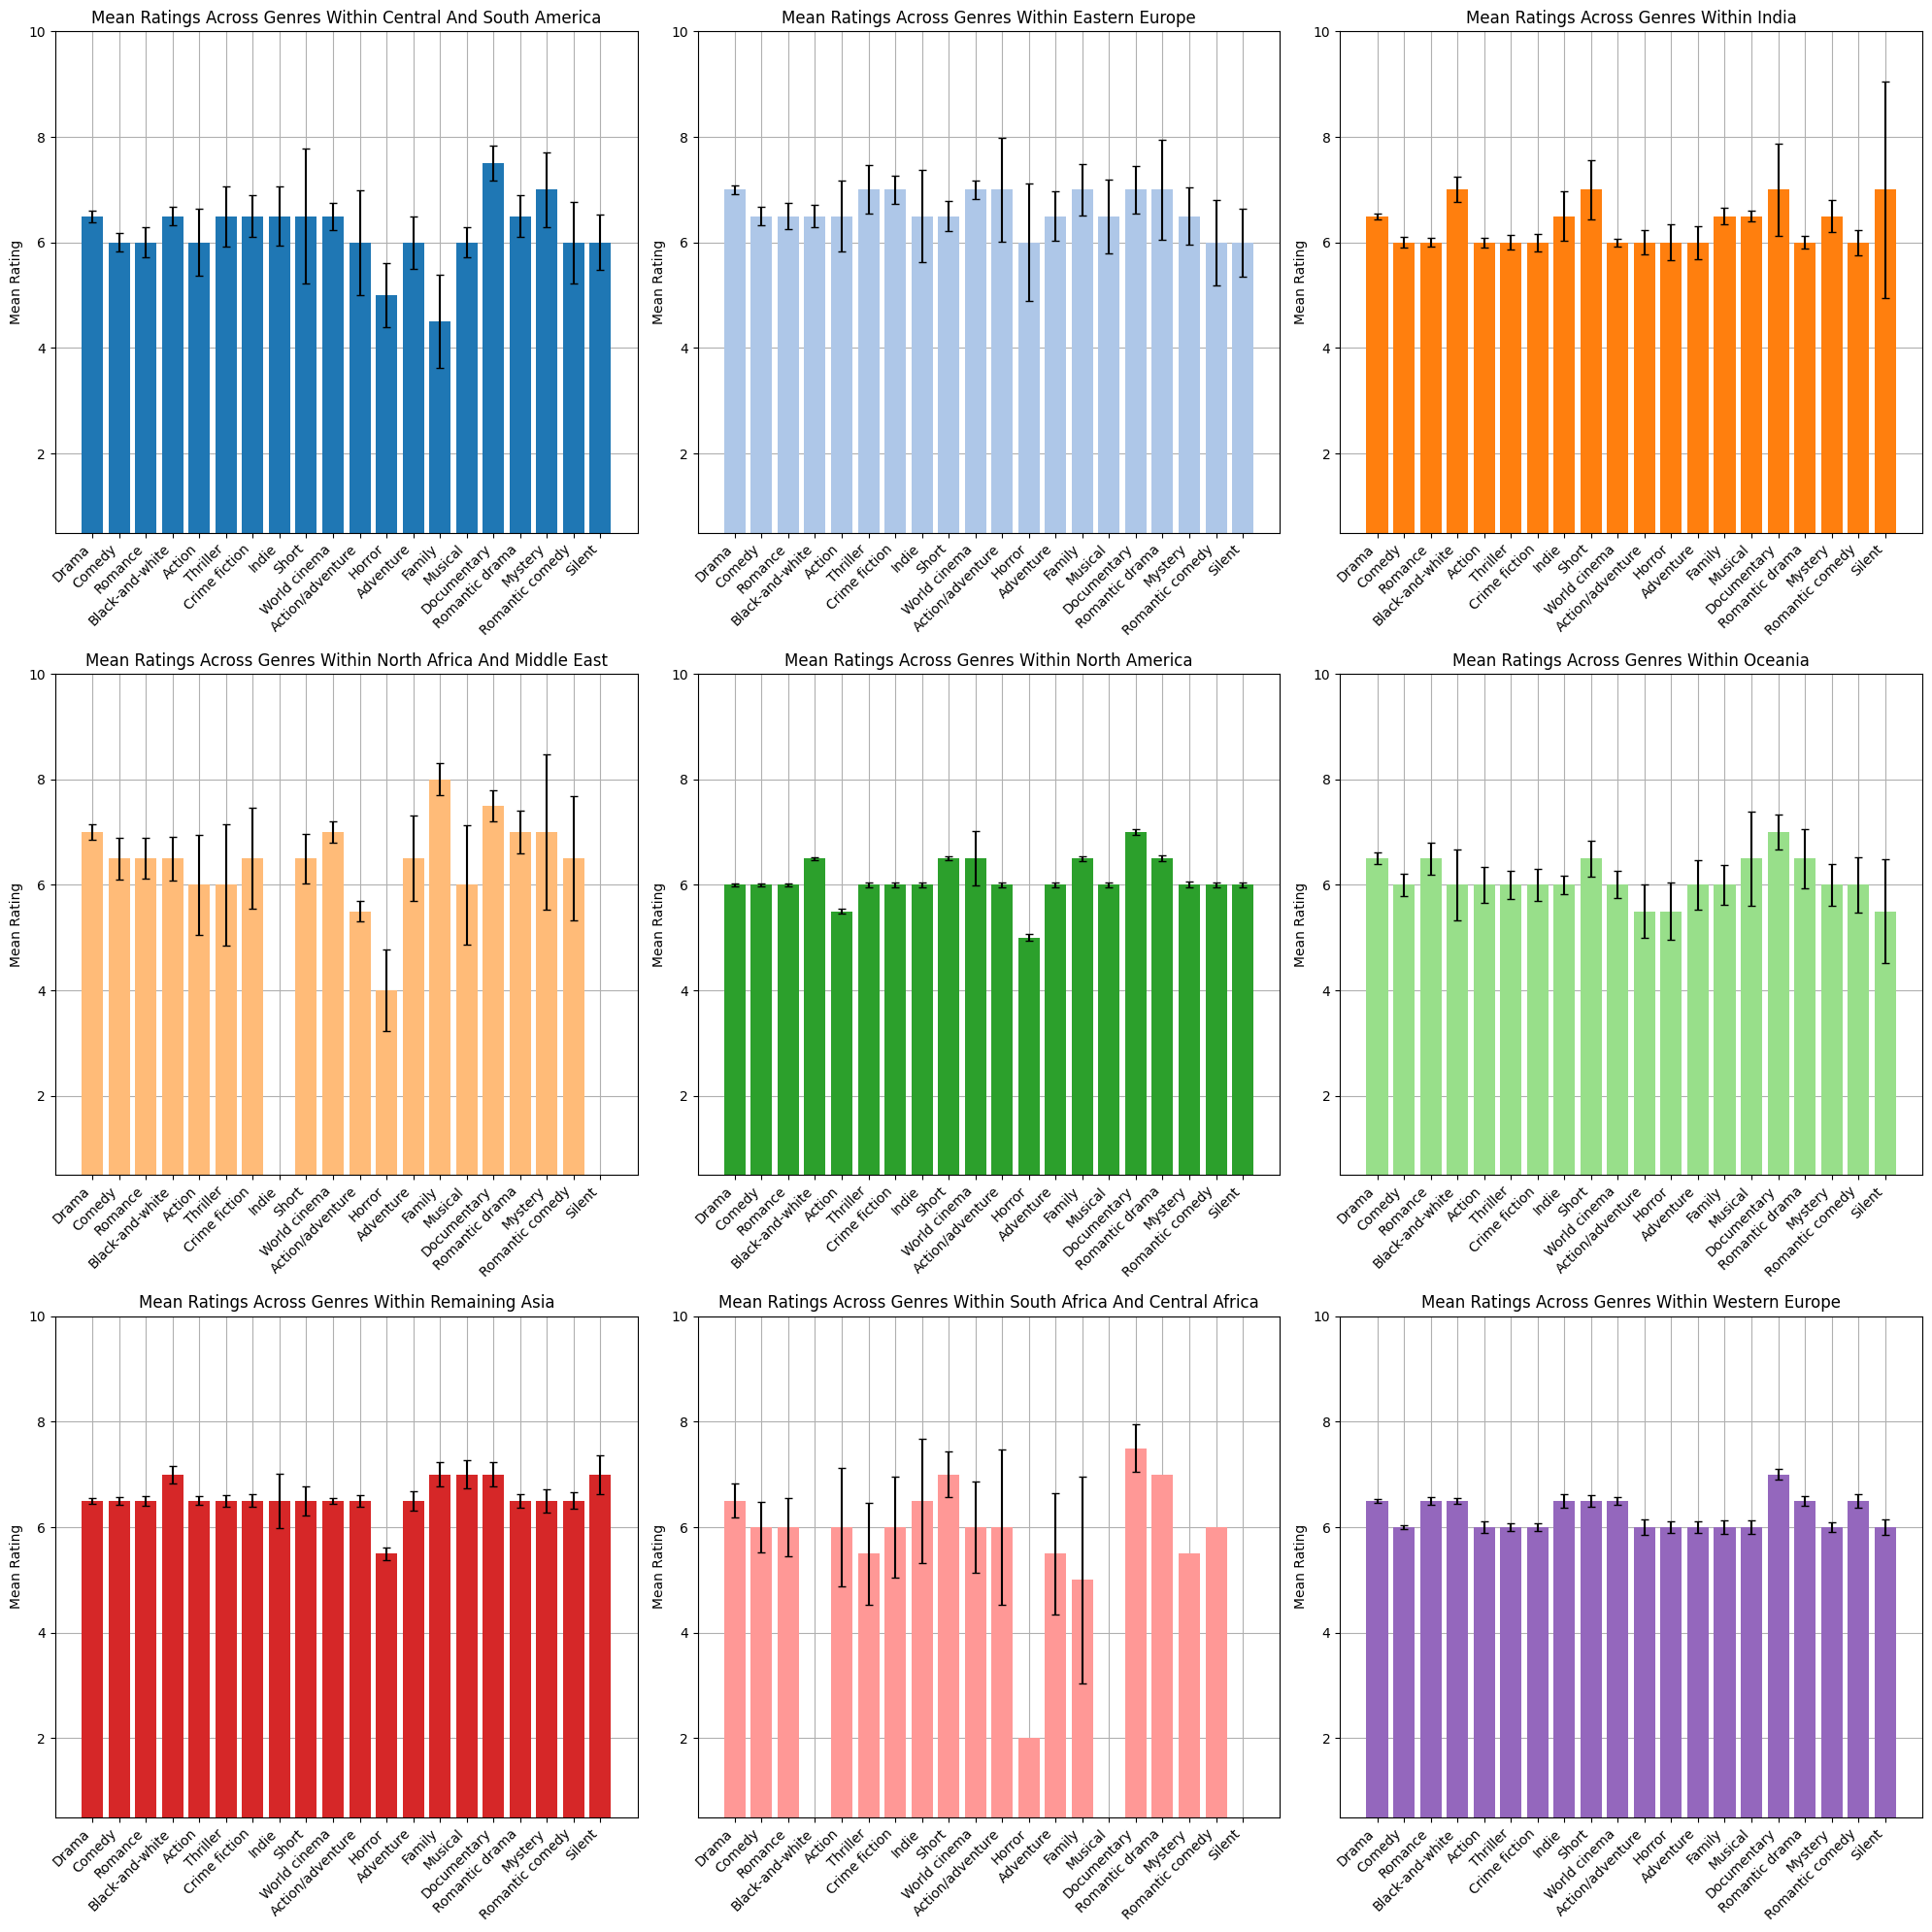

In [45]:
# Create a 3x3 grid for the subplots to fit 9 regions
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

# Plot each genre in the corresponding subplot
for i, region in enumerate(model_groupings):
    axs[i].bar(range(len(top_20_genres_list)), mean_ratings[region], yerr=confidence_intervals[region], capsize=3, color=colors[i], zorder=2)

    axs[i].grid(True, zorder=0)
    axs[i].set_xticks(range(len(top_20_genres_list)))
    axs[i].set_xticklabels(top_20_genres_list, rotation=45, ha='right')
    axs[i].set_title(f"Mean Ratings Across Genres Within {region.title()}")
    axs[i].set_ylabel("Mean Rating")
    axs[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now I want to observe how the mean rating per genre per region changes over time.

In [46]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings_regionfilled.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

In [47]:
# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

In [48]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["region"] == region]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    genre_mean_ratings = region_df.groupby(["genres", "decade"])

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Storing the mean ratings and confidence intervals for the genre in the region across decades
    region_means = np.zeros((20, 6))
    region_CI = np.zeros((20, 6))

    for i, genre in enumerate(top_20_genres_list):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if genre_mean_ratings_size.loc[(genre, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = genre_mean_ratings_regions_average.loc[(genre, decade), "averageRating"]
                region_CI[i][j] = genre_mean_ratings_regions_stderr.loc[(genre, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

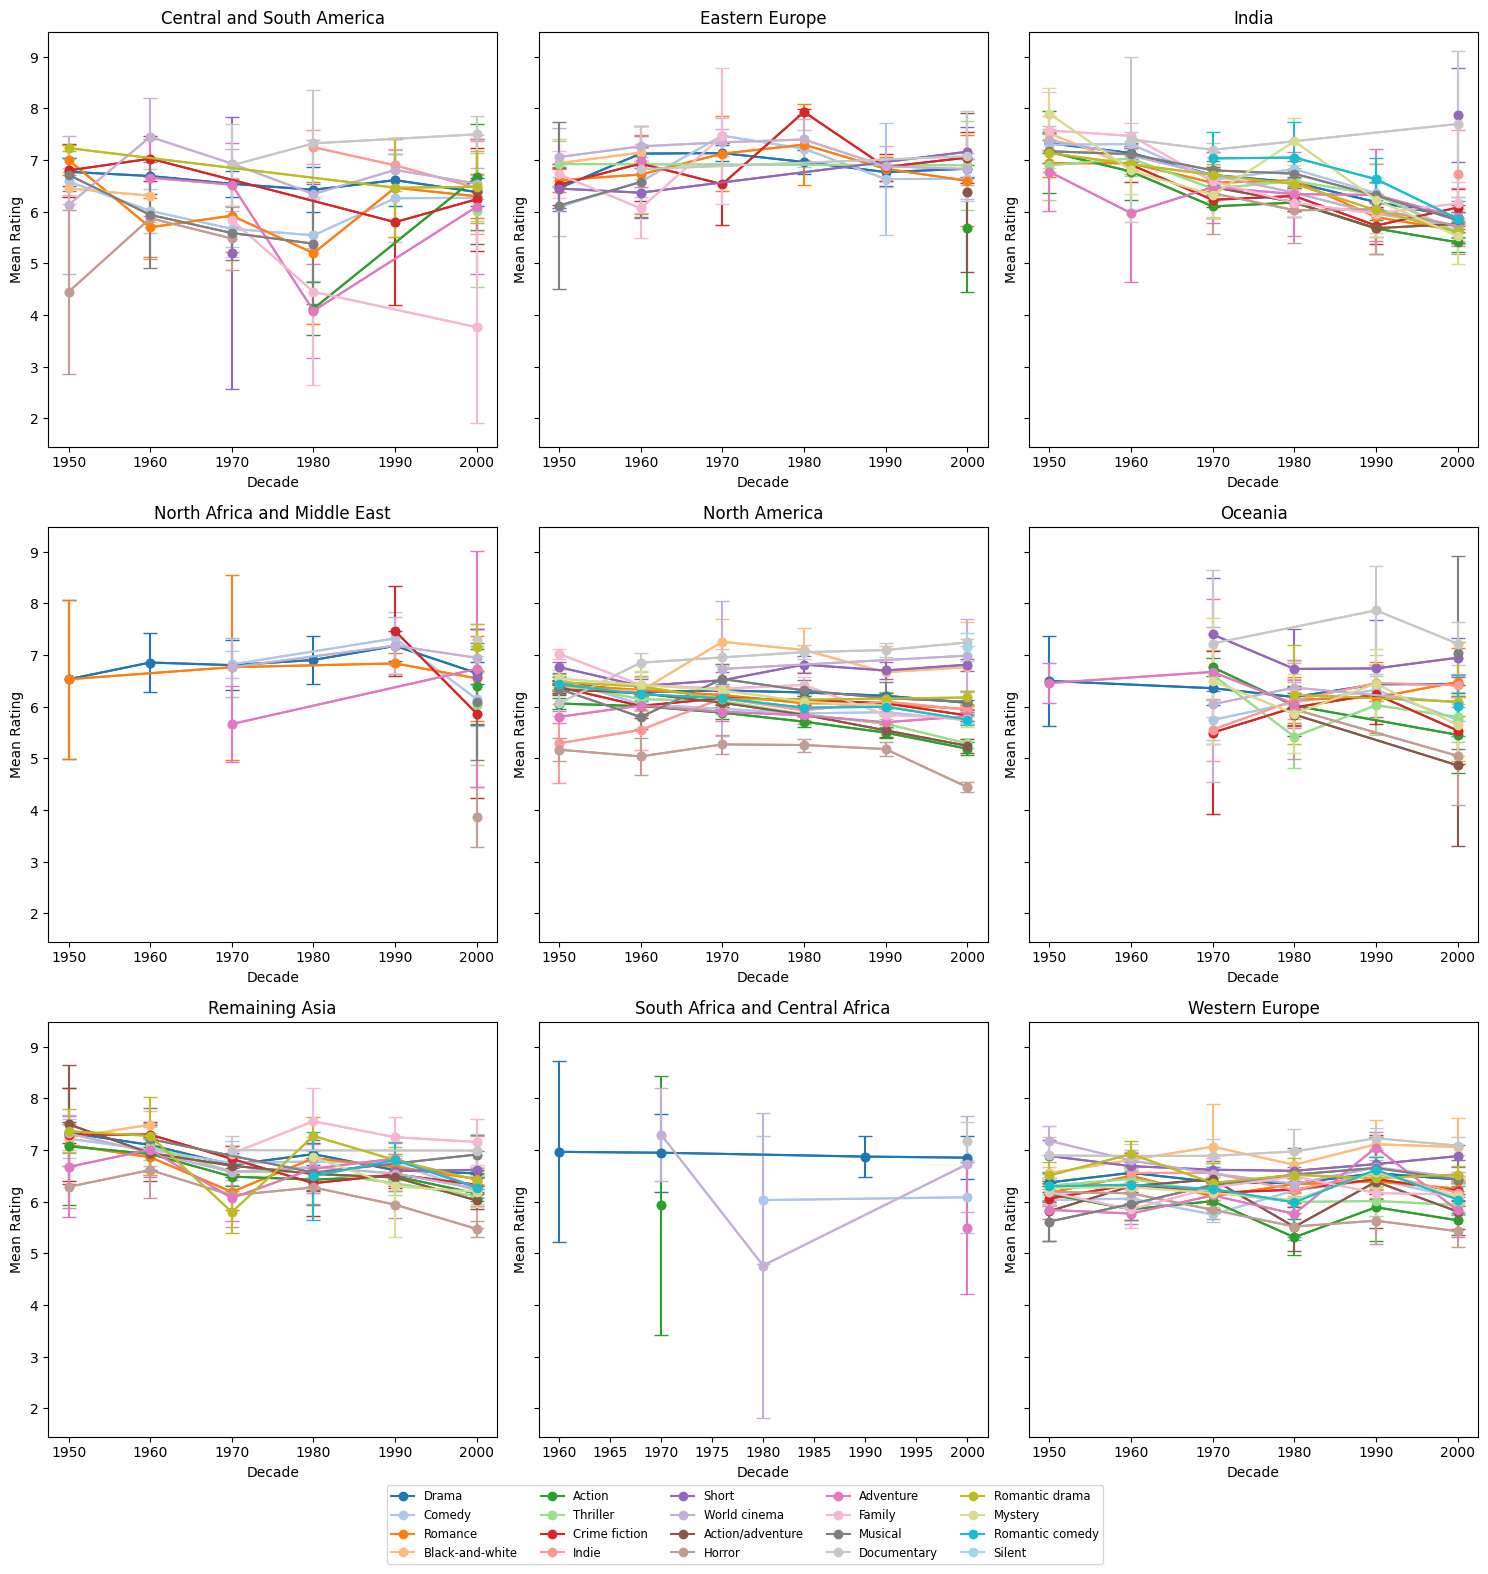

In [49]:
# Defining the subplots, with one per region
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per region of their mean ratings for the top 20 genres of films over the six decades considered
for i, region_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each genre is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[region_name], confidence_intervals[region_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of genre mean ratings over decades per region requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a genre with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the genres mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]

        # Defining the given genres color for plotting a line plot with error bars for every genres mean rating over the six decades in a given region
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=top_20_genres_list[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(region_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=top_20_genres_list, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

The above is great but with 20 genres, quite hard to visualize. Let's focus on the top 5 genres to make the observations more interprettable, recycling the code from above.

In [50]:
# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 5 genres as a list
top_5_genres = genre_counts.head(5).index.tolist()

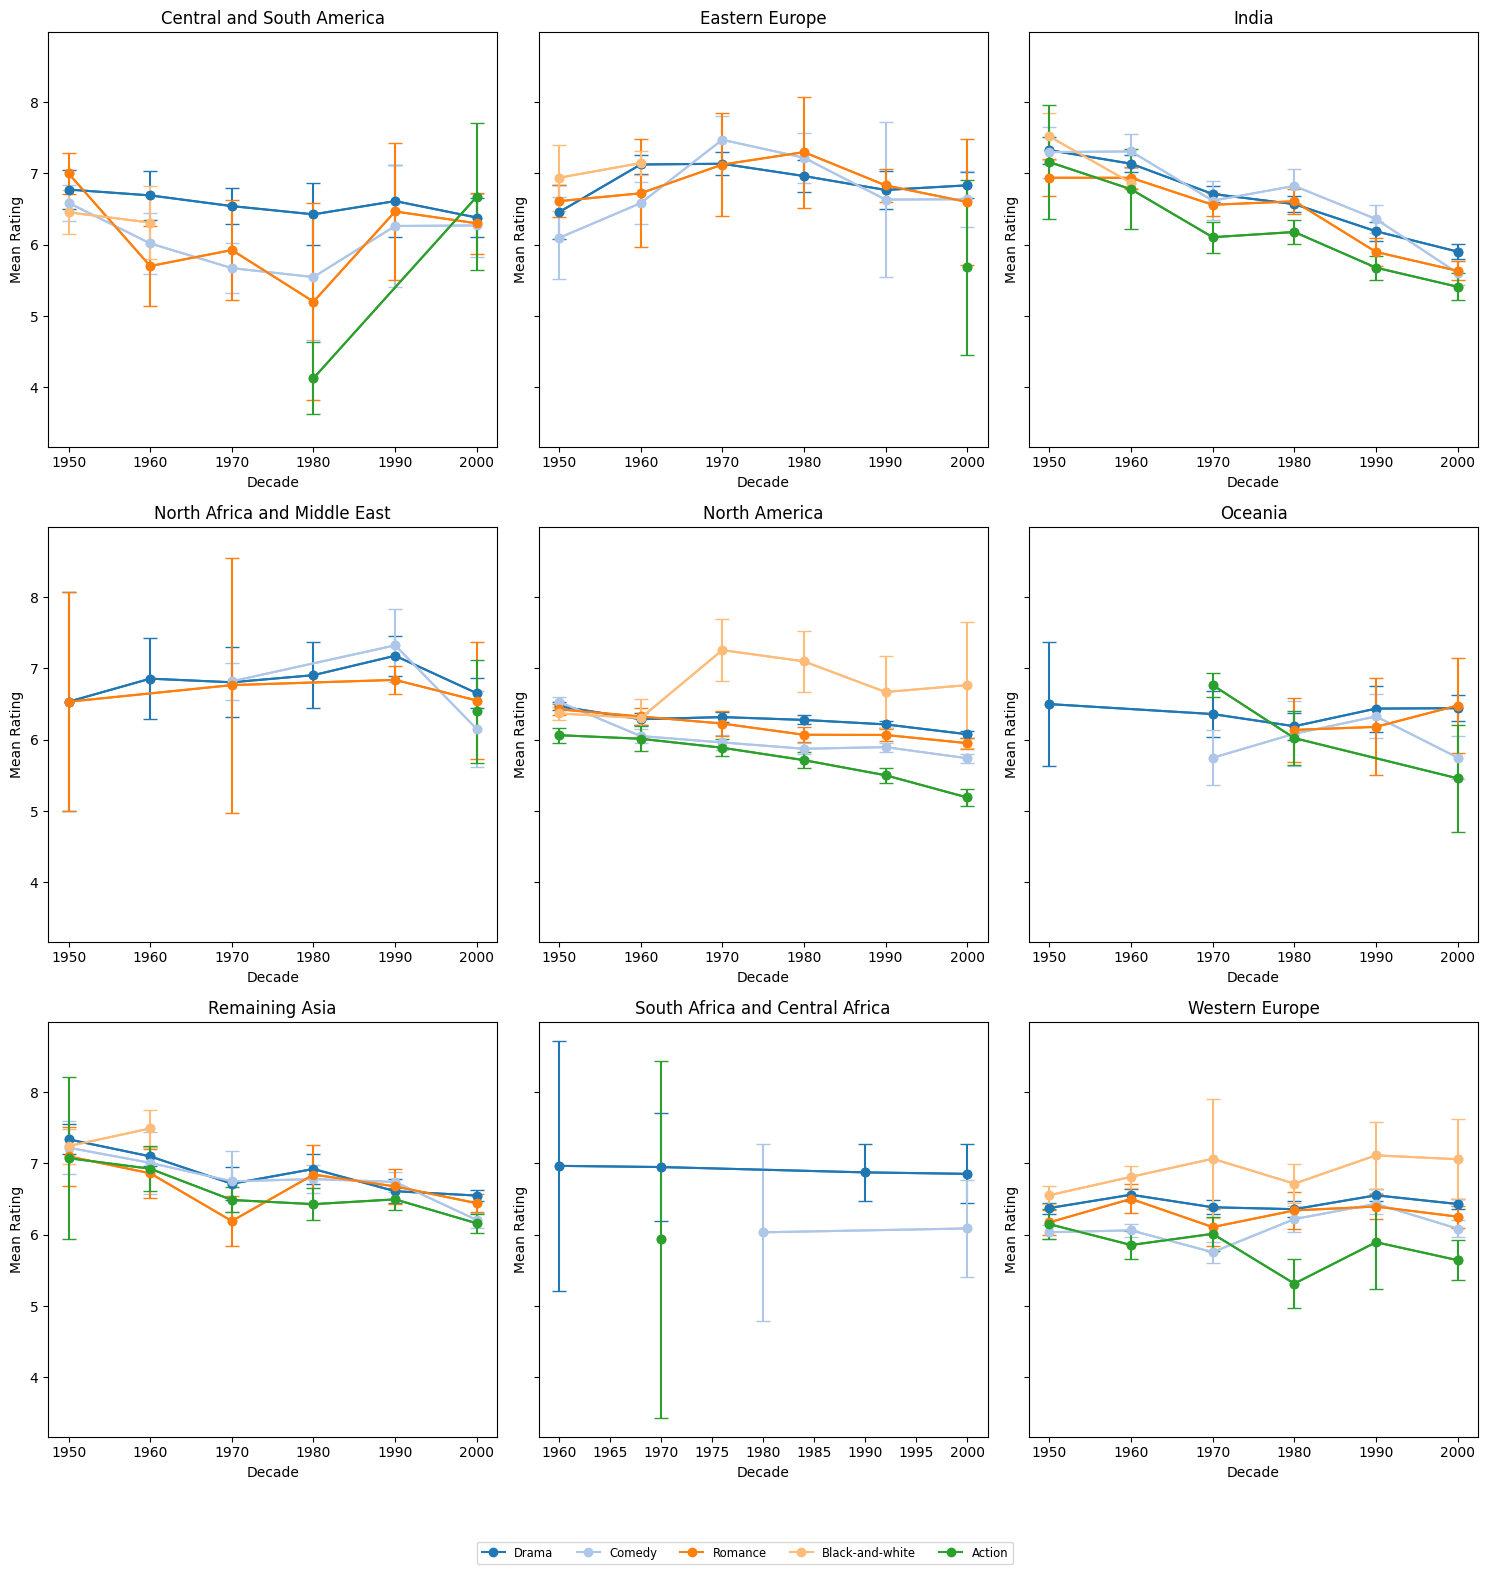

In [51]:

# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings_regionfilled.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each region to calculate the mean rating and CI per genre of film per region per decade
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["region"] == region]

    # Grouping by genre per decade and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    genre_mean_ratings = region_df.groupby(["genres", "decade"])

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Storing the mean ratings and confidence intervals for the genre in the region across decades
    region_means = np.zeros((5, 6))
    region_CI = np.zeros((5, 6))

    for i, genre in enumerate(top_5_genres):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if genre_mean_ratings_size.loc[(genre, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = genre_mean_ratings_regions_average.loc[(genre, decade), "averageRating"]
                region_CI[i][j] = genre_mean_ratings_regions_stderr.loc[(genre, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

    
# Defining the subplots, with one per region
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per region of their mean ratings for the top 5 genres of films over the six decades considered
for i, region_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each genre is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[region_name], confidence_intervals[region_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of genre mean ratings over decades per region requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a genre with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the genres mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]

        # Defining the given genres color for plotting a line plot with error bars for every genres mean rating over the six decades in a given region
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=top_5_genres[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(region_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=top_5_genres, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

Interesting! Let's now apply the analysis of comparing ratings across decades to analyzing the ratings across decades between regions per genre.

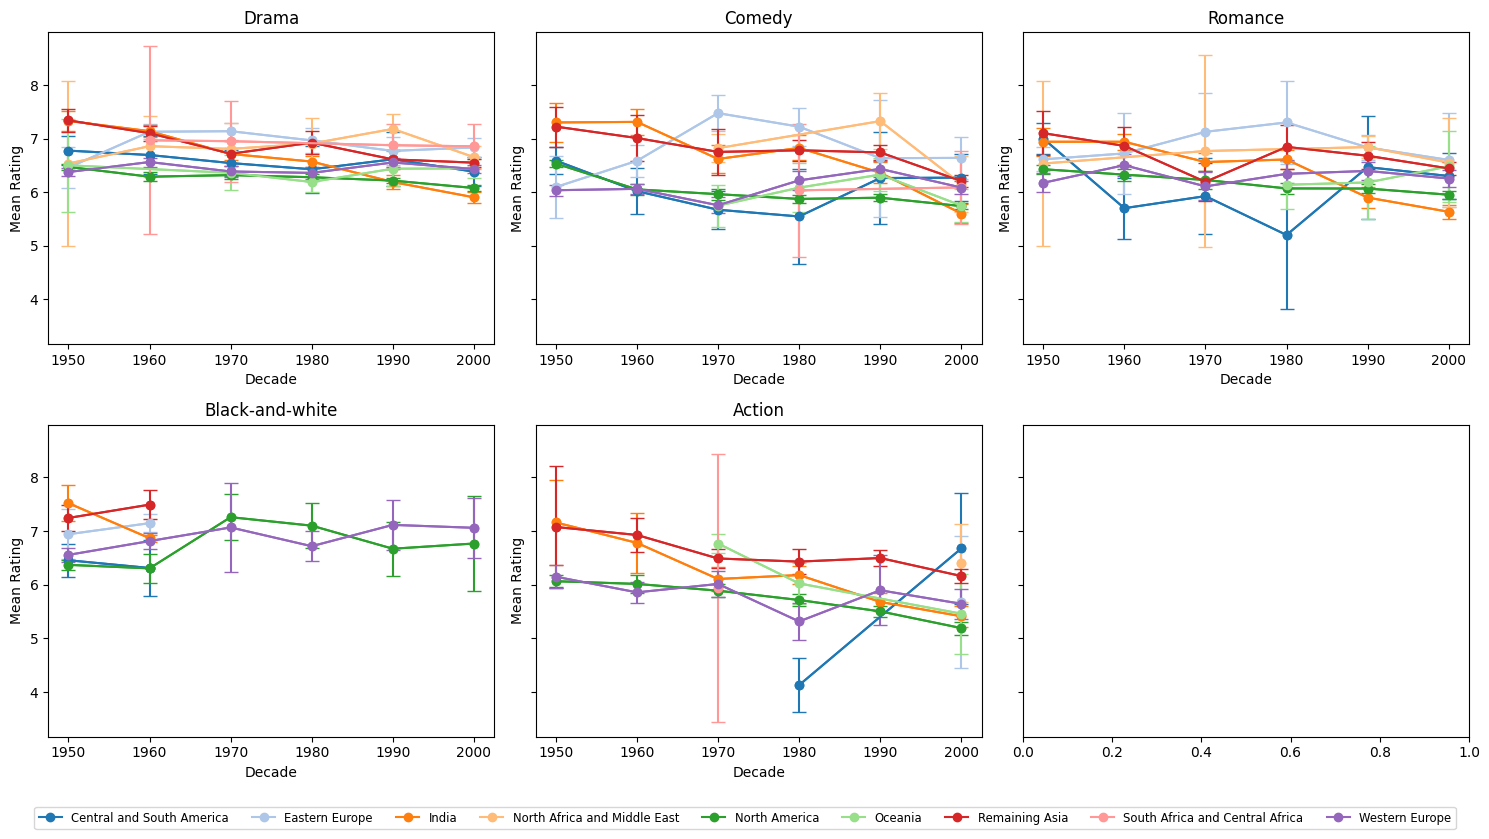

In [52]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per region per genre over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    region_mean_ratings = genre_df.groupby(["region", "decade"])

    region_mean_ratings_size = region_mean_ratings.size().sort_index()
    region_mean_ratings_regions_average = region_mean_ratings.mean("averageRating").sort_index()
    region_mean_ratings_regions_std = region_mean_ratings["averageRating"].std().sort_index()  
    region_mean_ratings_regions_stderr = region_mean_ratings_regions_std / np.sqrt(region_mean_ratings_size) 
    
    # Storing the mean ratings and confidence intervals for the region in the genre across decades
    region_means = np.zeros((9, 6))
    region_CI = np.zeros((9, 6))

    for i, region in enumerate(model_groupings):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if region_mean_ratings_size.loc[(region, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = region_mean_ratings_regions_average.loc[(region, decade), "averageRating"]
                region_CI[i][j] = region_mean_ratings_regions_stderr.loc[(region, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[genre] = region_means
    confidence_intervals[genre] = region_CI

# Defining the subplots, with one per genre
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

# Creating the subplot per genre of their mean ratings for the regions over the six decades considered
for i, genre_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each region is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[genre_name], confidence_intervals[genre_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of regional mean ratings over decades per genre requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a region with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the regional mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]
        
        # Defining the given genres color for plotting a line plot with error bars for every region's mean rating over the six decades in a given genre
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=model_groupings[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(genre_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=model_groupings, loc='lower center', ncol=9, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

Let's replicate the above over the top 20 genres.

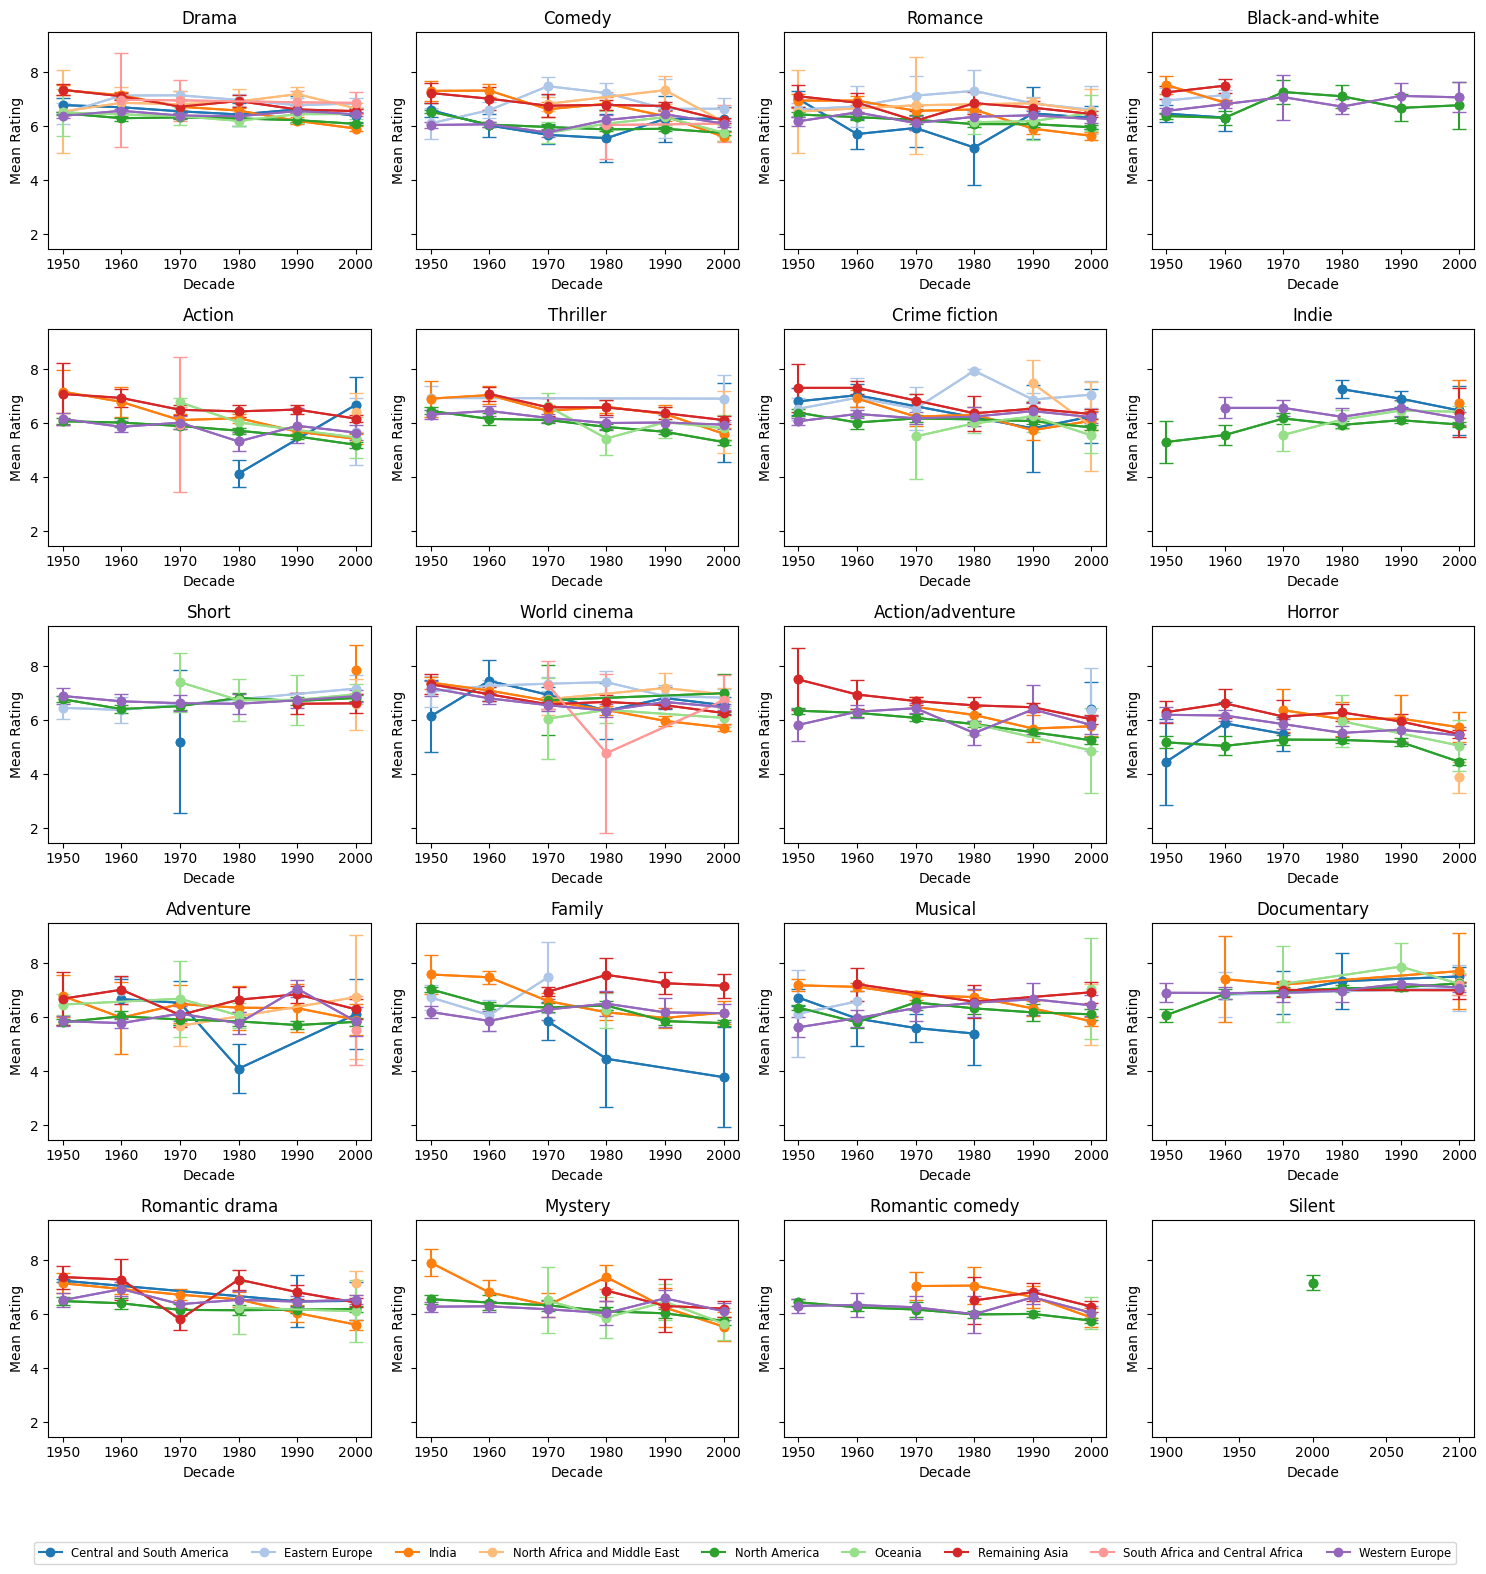

In [53]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per region per genre over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    region_mean_ratings = genre_df.groupby(["region", "decade"])

    region_mean_ratings_size = region_mean_ratings.size().sort_index()
    region_mean_ratings_regions_average = region_mean_ratings.mean("averageRating").sort_index()
    region_mean_ratings_regions_std = region_mean_ratings["averageRating"].std().sort_index()  
    region_mean_ratings_regions_stderr = region_mean_ratings_regions_std / np.sqrt(region_mean_ratings_size) 

    # Storing the mean ratings and confidence intervals for the region in the genre across decades
    region_means = np.zeros((9, 6))
    region_CI = np.zeros((9, 6))

    for i, region in enumerate(model_groupings):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if region_mean_ratings_size.loc[(region, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = region_mean_ratings_regions_average.loc[(region, decade), "averageRating"]
                region_CI[i][j] = region_mean_ratings_regions_stderr.loc[(region, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[genre] = region_means
    confidence_intervals[genre] = region_CI

# Defining the subplots, with one per genre
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per genre of their mean ratings for the regions over the six decades considered
for i, genre_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each region is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[genre_name], confidence_intervals[genre_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of regional mean ratings over decades per genre requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a region with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the regional mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]
        
        # Defining the given genres color for plotting a line plot with error bars for every region's mean rating over the six decades in a given genre
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=model_groupings[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(genre_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=model_groupings, loc='lower center', ncol=9, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

## Introduction Statistics

In [54]:
# wanting to analyze the significance of difference between ratings per region; there is complete independency of a given genre's ratings per region
# as no movies were exploded for country hence no movies can be counted in more than one region and the ratings are assumed to be normally distributed,
# hence ANOVA is performed to determine if within a given genre their ratings by region are statistically significantly different

# H_o = the null hypothesis: There is no significant difference among a given genre's rating means across movie regions
# H_a = the alternative hypothesis: There is a significant difference among a given genre's rating means across movie regions

p_values = {}
# Loop through each genre
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]

    C_SA_genre_ratings = genre_df[genre_df["region"] == "Central and South America"]
    C_SA_genre_ratings_list = C_SA_genre_ratings["averageRating"].to_list()

    EU_genre_ratings = genre_df[genre_df["region"] == "Eastern Europe"]
    EU_genre_ratings_list = EU_genre_ratings["averageRating"].to_list()

    India_genre_ratings = genre_df[genre_df["region"] == "India"]
    India_genre_ratings_list = India_genre_ratings["averageRating"].to_list()

    NA_ME_genre_ratings = genre_df[genre_df["region"] == "North Africa and Middle East"]
    NA_ME_genre_ratings_list = NA_ME_genre_ratings["averageRating"].to_list()

    NA_genre_ratings = genre_df[genre_df["region"] == "North America"]
    NA_genre_ratings_list = NA_genre_ratings["averageRating"].to_list()

    Oceania_genre_ratings = genre_df[genre_df["region"] == "Oceania"]
    Oceania_genre_ratings_list = Oceania_genre_ratings["averageRating"].to_list()

    RA_genre_ratings = genre_df[genre_df["region"] == "Remaining Asia"]
    RA_genre_ratings_list = RA_genre_ratings["averageRating"].to_list()

    SA_CA_genre_ratings = genre_df[genre_df["region"] == "South Africa and Central Africa"]
    SA_CA_genre_ratings_list = SA_CA_genre_ratings["averageRating"].to_list()

    WE_genre_ratings = genre_df[genre_df["region"] == "Western Europe"]
    WE_genre_ratings_list = WE_genre_ratings["averageRating"].to_list()

    # Checking if all regions in a given genre have ratings that aren't the filler 0 values
    if all(len(ratings) > 0 and all(rating != 0.0 for rating in ratings) for ratings in [
        C_SA_genre_ratings_list, EU_genre_ratings_list, India_genre_ratings_list,
        NA_ME_genre_ratings_list, NA_genre_ratings_list, Oceania_genre_ratings_list,
        RA_genre_ratings_list, SA_CA_genre_ratings_list, WE_genre_ratings_list]):
        
        # Performing ANOVA
        result = f_oneway(
            C_SA_genre_ratings_list, EU_genre_ratings_list, India_genre_ratings_list,
            NA_ME_genre_ratings_list, NA_genre_ratings_list, Oceania_genre_ratings_list,
            RA_genre_ratings_list, SA_CA_genre_ratings_list, WE_genre_ratings_list)
        
        p_values.update({str(genre): result[1]})

    else:
        # If any region lacks data, store None or a placeholder
        p_values.update({str(genre): None})
    
p_values

{'Drama': 3.734939857755582e-76,
 'Comedy': 5.783667186929154e-20,
 'Romance': 1.7245632740233807e-15,
 'Black-and-white': None,
 'Action': 6.701755222079412e-20,
 'Thriller': 4.507231533166641e-22,
 'Crime fiction': 1.0266434081051335e-08,
 'Indie': None,
 'Short': 0.012018515781525034,
 'World cinema': 1.6166438235450037e-28,
 'Action/adventure': 4.1147906550403543e-13,
 'Horror': 3.922094657659255e-37,
 'Adventure': 4.173446652972904e-06,
 'Family': 9.241241645833469e-14,
 'Musical': None,
 'Documentary': 0.454672360350329,
 'Romantic drama': 2.957617165797003e-13,
 'Mystery': 0.004960324709722832,
 'Romantic comedy': 0.11931435944465403,
 'Silent': None}

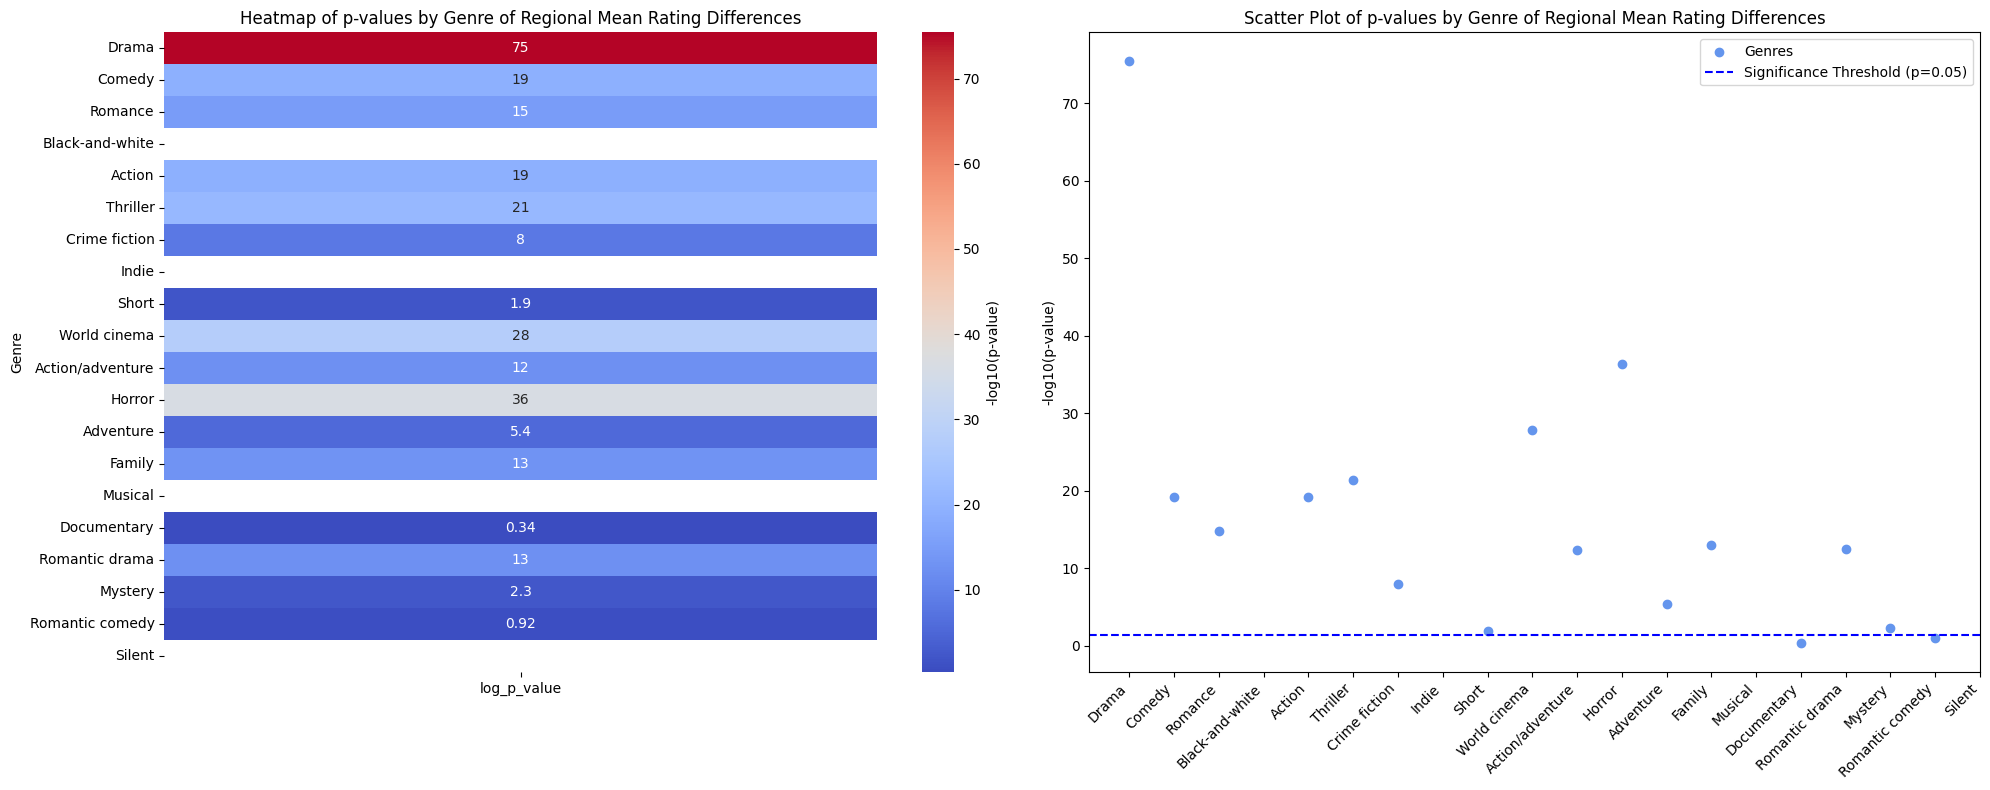

In [55]:
# To help plot (in various ways) the ANOVA p-value per genre, the above test results are converted to a DataFrame
df_genre_region_p_value = pd.DataFrame(list(p_values.items()), columns=['Genre', 'p-value'])

# Converting p-values to a heatmap-friendly range (log scale for better visualization)
df_genre_region_p_value['log_p_value'] = -df_genre_region_p_value['p-value'].apply(lambda x: np.log10(x) if x > 0 else None)

# A heat map is first prepared to observe which genres have significant in mean ratings across regions
heatmap_data = df_genre_region_p_value.set_index('Genre')[['log_p_value']]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create heatmap
# Plot heatmap
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': '-log10(p-value)'}, ax=axes[0])
axes[0].set_title('Heatmap of p-values by Genre of Regional Mean Rating Differences')

# Scatter plot
top_20_genres_list = df_genre_region_p_value['Genre'].tolist()
axes[1].scatter(top_20_genres_list, df_genre_region_p_value['log_p_value'], color='cornflowerblue', label='Genres')
axes[1].axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='Significance Threshold (p=0.05)')
axes[1].set_xticks(range(len(top_20_genres_list)))
axes[1].set_xticklabels(top_20_genres_list, rotation=45, ha='right')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_title('Scatter Plot of p-values by Genre of Regional Mean Rating Differences')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Most movies genres reject that there is no statistically significant difference in their ratings across regions and therefore we consider regional differences to have an impact on the mean ratings per genre. Documentaries and romantic comedies are the sole movies that fail to conclude a statistically significant difference in their mean ratings seperated by movie country.

Now we aim to understand if there is significance in the mean ratings across genres for a given movie region. For this, new hypothesis tests are prepared:

H_o = the null hypothesis: There is no significant difference among a given region's mean ratings across genres
H_a = the alternative hypothesis: There is a significant difference among a given region's mean ratings across genres

As there are some movies that appear in more than one genre, then we have to consider that we are in a situation where our samples are not entirely independent, which is a requirement for using one-way ANOVA testing, and hence the sample ratings may not fit a normal distribution. As a result, a Kruskal-Wallis Test is used per regional groupign of movies. A linear-mixed model would also be applicable for such an analysis, however, this test requires a linear relationship between the ratings and genre hot-encoded features, which we cannot prove. The Kruskal-Wallis Test is therefore called on each regional grouping.

In [56]:
# Looping through each region
for region in model_groupings:
    print(f"Results for region: {region}")
    
    # Dividing the data for the region
    df_region = df_movies_tmdb_ratings[df_movies_tmdb_ratings['region'] == region]
    
    # Collecting ratings for each genre
    genre_groups = []

    # Grouping the regional movies by genres
    for genre, group in df_region.groupby('genres'):
        # Extracting the ratings column for the current genre and append it as an array to the list of genre ratings
        ratings = group['averageRating'].values
        genre_groups.append(ratings)    

    # Performing the Kruskal-Wallis test across the genres by unpacking each list of ratings per genre
    if len(genre_groups) > 1:
        stat, p_value = kruskal(*genre_groups)
        print(f"Kruskal-Wallis Statistic: {stat:.4f}, p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in {region}.")
        else:
            print(f"The null hypothesis is failed to be rejected and a statistically significant difference in ratings across genres cannot be claimed for movies in {region}.")
    
    # Formatting in a clear way
    print("\n" + "-"*50 + "\n")


Results for region: Central and South America
Kruskal-Wallis Statistic: 91.6798, p-value: 0.0000
There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Central and South America.

--------------------------------------------------

Results for region: Eastern Europe
Kruskal-Wallis Statistic: 24.0532, p-value: 0.1941
The null hypothesis is failed to be rejected and a statistically significant difference in ratings across genres cannot be claimed for movies in Eastern Europe.

--------------------------------------------------

Results for region: India
Kruskal-Wallis Statistic: 181.0209, p-value: 0.0000
There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in India.

--------------------------------------------------

Results for region: North Africa and Middle East
Kruskal-Wallis Statistic: 45.5060, p-value: 0.0002
There null hypothes

### Genres , Time and Regions VS Ratings 

Main Effects:

Genres: Do ratings differ across genres?
Decades: Do ratings change over time (across decades)?
Regions: Do ratings differ across regions?
Two-Way Interaction Effects:

Genres × Decades: Does the evolution of ratings over time differ for genres?
Genres × Regions: Do ratings for genres vary across regions?
Decades × Regions: Does the evolution of ratings over time differ across regions?
Three-Way Interaction:

Genres × Decades × Regions: Does the evolution of ratings for genres over time depend on the region?

In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model
model = ols("averageRating ~ C(genres) * C(region) * C(decade)", data=df_movies_tmdb_ratings_region_decade_filled).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=3)  # Type 3 includes interaction terms
print("Three-Way ANOVA Results:")
print(anova_table)


Three-Way ANOVA Results:
                                     sum_sq       df          F         PR(>F)
Intercept                         85.805000      1.0  79.183041   5.834107e-19
C(genres)                        251.791853     19.0  12.229471   1.404168e-38
C(region)                         84.953856      8.0   9.799698   1.052332e-13
C(decade)                         16.400000      5.0   3.026868   9.810454e-03
C(genres):C(region)             1488.293112    152.0   9.035755  1.462826e-192
C(genres):C(decade)              793.285492     95.0   7.705938   3.497497e-98
C(region):C(decade)              305.428268     40.0   7.046425   5.300636e-38
C(genres):C(region):C(decade)   5659.550479    760.0   6.872076   0.000000e+00
Residual                       57886.350560  53419.0        NaN            NaN


From this test we see that genres, regions and decades have significant impact on ratings, but also their interactions! 

In [62]:
# Convert to numeric (integer)
df_movies_tmdb_ratings_region_decade_filled['decade'] = pd.to_numeric(df_movies_tmdb_ratings_region_decade_filled['decade'], errors='coerce')


In [66]:
slopes_data = []

# Group by region and genre
for (region, genre), group in df_movies_tmdb_ratings_region_decade_filled.groupby(['region', 'genres']):
    group = group.sort_values('decade')  # Sort by decade
    
    # Group by decade and calculate the mean rating for each decade
    decade_means = group.groupby('decade')['averageRating'].mean().reset_index()

    # Loop through consecutive decades
    for i in range(1, len(decade_means)):
        decade1 = decade_means.iloc[i-1]
        decade2 = decade_means.iloc[i]
        
        # Calculate slope between two consecutive decades
        slope = (decade2['averageRating'] - decade1['averageRating']) / (decade2['decade'] - decade1['decade'])
        
        # Store results
        slopes_data.append({
            'region': region,
            'genre': genre,
            'decade1': decade1['decade'],
            'decade2': decade2['decade'],
            'slope': slope
        })

# Convert to DataFrame
slopes_df = pd.DataFrame(slopes_data)


In [67]:
# Dictionary to store top and worst genres between consecutive decades and regions
top_worst_data = []

# Group by region
for region, group in slopes_df.groupby('region'):
    # Group by consecutive decades within the region
    for decade_pair, decade_group in group.groupby(['decade1', 'decade2']):
        # Find top and worst genres within the current decade pair
        top_genre = decade_group.loc[decade_group['slope'].idxmax()]
        worst_genre = decade_group.loc[decade_group['slope'].idxmin()]

        # Store the results
        top_worst_data.append({
            'region': region,
            'decade1': decade_pair[0],
            'decade2': decade_pair[1],
            'top_genre': top_genre['genre'],
            'top_slope': top_genre['slope'],
            'worst_genre': worst_genre['genre'],
            'worst_slope': worst_genre['slope']
        })

# Convert to DataFrame
top_worst_df = pd.DataFrame(top_worst_data)

                             region  decade1  decade2         top_genre  \
0         Central and South America   1950.0   1960.0   Romantic comedy   
1         Central and South America   1960.0   1970.0  Action/adventure   
2         Central and South America   1970.0   1980.0             Short   
3         Central and South America   1980.0   1990.0    Romantic drama   
4         Central and South America   1990.0   2000.0           Mystery   
5                    Eastern Europe   1950.0   1960.0            Horror   
6                    Eastern Europe   1960.0   1970.0           Musical   
7                    Eastern Europe   1970.0   1980.0  Action/adventure   
8                    Eastern Europe   1980.0   1990.0          Thriller   
9                    Eastern Europe   1990.0   2000.0            Silent   
10                            India   1950.0   1960.0       Documentary   
11                            India   1960.0   1970.0   Romantic comedy   
12                       

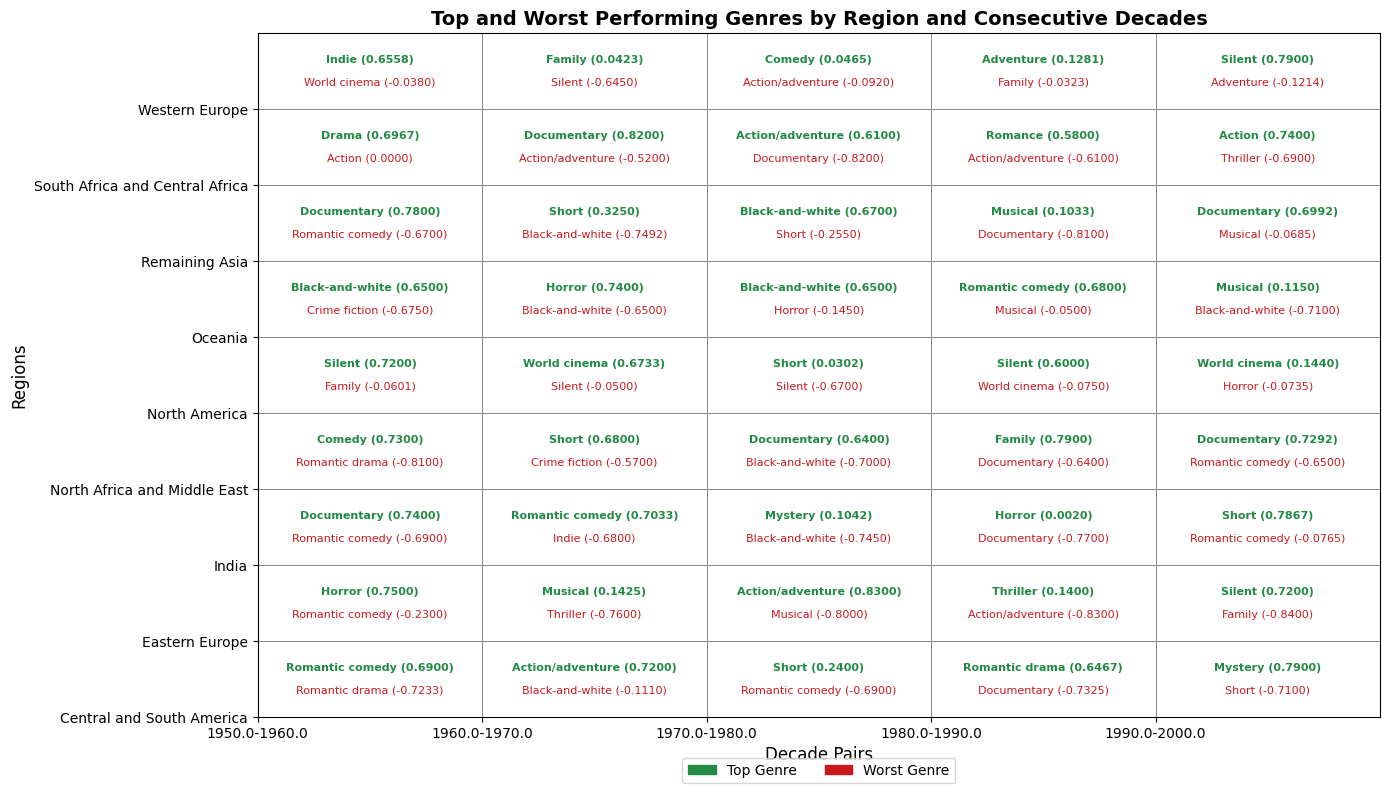

In [68]:
# Define decades and regions
decade_pairs = sorted(top_worst_df[['decade1', 'decade2']].drop_duplicates().values.tolist())
regions = sorted(top_worst_df['region'].unique())

# Flatten the decade pairs for visualization
decade_labels = [f"{d1}-{d2}" for d1, d2 in decade_pairs]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set axis limits and labels
ax.set_xlim(0, len(decade_labels))
ax.set_ylim(0, len(regions))
ax.set_xticks(range(len(decade_labels)))
ax.set_yticks(range(len(regions)))
ax.set_xticklabels(decade_labels, fontsize=10)
ax.set_yticklabels(regions, fontsize=10)
ax.grid(visible=True, which='major', linestyle='-', linewidth=0.5)

# Define colors
top_color = sns.color_palette("Greens", n_colors=3)[2]  # Dark green
worst_color = sns.color_palette("Reds", n_colors=3)[2]  # Dark red

# Loop through the grid
for i, region in enumerate(regions):
    for j, (decade1, decade2) in enumerate(decade_pairs):
        # Get data for current cell
        cell_data = top_worst_df[
            (top_worst_df['decade1'] == decade1) & 
            (top_worst_df['decade2'] == decade2) & 
            (top_worst_df['region'] == region)
        ]
        
        if not cell_data.empty:
            top_genre = cell_data['top_genre'].values[0]
            top_slope = cell_data['top_slope'].values[0]
            worst_genre = cell_data['worst_genre'].values[0]
            worst_slope = cell_data['worst_slope'].values[0]
            
            # Position text
            x_center, y_center = j + 0.5, i + 0.5
            
            # Draw background square
            ax.add_patch(patches.Rectangle((j, i), 1, 1, color="white", ec="black", lw=0.5))
            
            # Add Top genre (upper part)
            ax.text(x_center, y_center + 0.15, f"{top_genre} ({top_slope:.4f})", 
                    ha='center', va='center', fontsize=8, color=top_color, fontweight='bold')
            
            # Add Worst genre (lower part)
            ax.text(x_center, y_center - 0.15, f"{worst_genre} ({worst_slope:.4f})", 
                    ha='center', va='center', fontsize=8, color=worst_color, fontweight='normal')

# Add legend
handles = [
    patches.Patch(color=top_color, label="Top Genre"),
    patches.Patch(color=worst_color, label="Worst Genre")
]
ax.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=10)

# Titles and labels
plt.title("Top and Worst Performing Genres by Region and Consecutive Decades", fontsize=14, fontweight='bold')
plt.xlabel("Decade Pairs", fontsize=12)
plt.ylabel("Regions", fontsize=12)

plt.tight_layout()
plt.show()


In [78]:
#performing anova on slopes between different decades for different genre-region combinations
anova_results = []

# Loop through each genre-region pair
for genre in top_5_genres:
    for region in regions:
        # Filter data for the current genre-region combination
        subset_df = df_movies_tmdb_ratings_region_decade_filled[
            (df_movies_tmdb_ratings_region_decade_filled['genres'] == genre) &
            (df_movies_tmdb_ratings_region_decade_filled['region'] == region)
        ]
        
        # Group ratings by decade
        ratings_by_decade = [
            group['averageRating'].values 
            for _, group in subset_df.groupby('decade')
        ]
        
        # Perform ANOVA if there are at least two decades with data
        if all(len(ratings) > 1 for ratings in ratings_by_decade):
            f_stat, p_value = f_oneway(*ratings_by_decade)
            
            # Store the result
            anova_results.append({
                'genre': genre,
                'region': region,
                'f_stat': f_stat,
                'p_value': p_value,
                'significant': p_value < 0.05  # True if p-value < 0.05
            })
        else:
            # If not enough data for ANOVA, skip this combination
            anova_results.append({
                'genre': genre,
                'region': region,
                'f_stat': None,
                'p_value': None,
                'significant': False
            })

# Convert results to df
anova_results_df = pd.DataFrame(anova_results)

# Print region-genre combos that have significant changes 
significant_results = anova_results_df[anova_results_df['significant']]
print("Significant Results:")
print(significant_results)


Significant Results:
              genre                     region     f_stat       p_value  \
0             Drama              North America  18.414591  3.492335e-18   
2             Drama             Remaining Asia  13.962152  4.150508e-13   
3             Drama             Western Europe   3.959657  1.409835e-03   
4             Drama             Eastern Europe   4.874727  2.670461e-04   
6             Drama                      India  49.856161  7.811295e-49   
9            Comedy              North America  45.172831  1.218288e-45   
11           Comedy             Remaining Asia  10.767192  9.594939e-10   
12           Comedy             Western Europe   9.984741  2.165789e-09   
13           Comedy             Eastern Europe   4.749500  5.557032e-04   
15           Comedy                      India  23.513940  1.308143e-21   
16           Comedy  Central and South America   2.771822  2.076848e-02   
18          Romance              North America  13.461333  6.277196e-13   
20  

# find a way to make plot better 

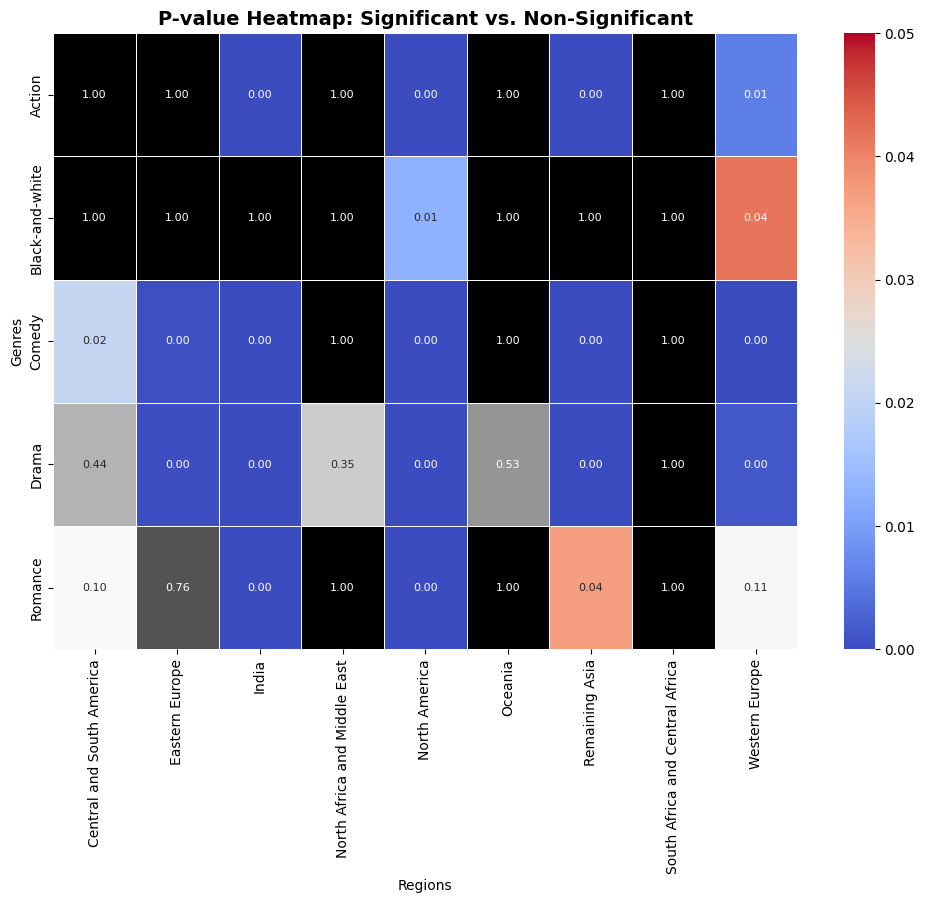

In [76]:
# Create a pivot table with p-values
heatmap_data = anova_results_df.pivot(index='genre', columns='region', values='p_value')

# Replace NaNs with a high p-value (e.g., 1) for visualization
heatmap_data = heatmap_data.fillna(1)

# Create a mask for non-significant p-values (p >= 0.05)
mask = heatmap_data >= 0.05

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            linewidths=0.5, annot_kws={"fontsize": 8}, mask=mask, 
            vmin=0, vmax=0.05)  # Color scale for significant p-values

# Overlay the non-significant cells in a neutral color (e.g., gray)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Greys", cbar=False,
            linewidths=0.5, annot_kws={"fontsize": 8}, mask=~mask, 
            vmin=0.05, vmax=1)

# Add title and labels
plt.title("P-value Heatmap: Significant vs. Non-Significant", fontsize=14, fontweight='bold')
plt.xlabel("Regions")
plt.ylabel("Genres")
plt.show()

